# 라이브러리 및 데이터 호출

In [2]:
# 라이브러리 호출 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import scikit_posthocs as sp
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr
from statsmodels.stats.descriptivestats import sign_test




# plt 폰트 설정 
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [3]:
# 데이터 호출
data = pd.read_csv("C:/Users/dlwlg/Desktop/final/상권지수/피처엔지니어링일단다한통합데이터.csv")

# Step 01 포화도 라벨링 기준 정하기
**경쟁강도 :: 상권 점포수 / 행정동 점포수**  
매출경쟁도 :: 상권 당월 매출 / 해당 행정동 당월 매출  
상권밀집도 :: 상권 점포수 / 상권 면적

포화지수 = (경쟁강도 * 0.4) + (매출경쟁도 * 0.4) + (상권밀집도 * 0.2)

In [4]:
# 포화도 기준용 데이터프레임 생성 
data_label = data[['기준_년분기_코드','상권_코드_명','유사_업종_점포_수','행정동_코드_명','자치구_코드_명']]

In [5]:
# 업종 상관 없이 상권 내에서 점포수 sum
data_label = data_label.groupby(['기준_년분기_코드','상권_코드_명','행정동_코드_명','자치구_코드_명'])['유사_업종_점포_수'].sum().reset_index()

# 업종 상관 없이 행정동 내에서 점포수 sum
admin_store_counts = data_label.groupby(['기준_년분기_코드','행정동_코드_명'])['유사_업종_점포_수'].sum().reset_index()
admin_store_counts.rename(columns={'유사_업종_점포_수': '행정동 내 점포수'}, inplace=True)

# 원본 데이터와 병합
data_label = data_label.merge(admin_store_counts, on=['기준_년분기_코드','행정동_코드_명'], how='left')

In [6]:
# 경쟁강도 칼럼 만들기
data_label['경쟁강도'] = data_label['유사_업종_점포_수'] / data_label['행정동 내 점포수']

# 결과 확인
print(data_label.head())

   기준_년분기_코드        상권_코드_명 행정동_코드_명 자치구_코드_명  유사_업종_점포_수  행정동 내 점포수      경쟁강도
0      20191   4.19민주묘지역 2번      우이동      강북구          34        282  0.120567
1      20191           63빌딩      여의동     영등포구          70       2909  0.024063
2      20191  DMC(디지털미디어시티)      상암동      마포구         600        945  0.634921
3      20191      GS강동자이아파트       길동      강동구         101       1698  0.059482
4      20191            G타워     구로3동      구로구          26       2287  0.011369


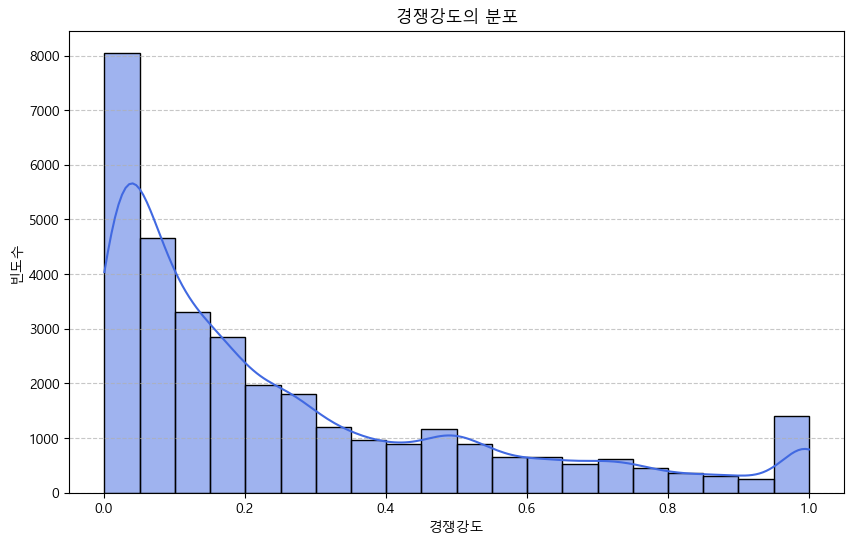

In [7]:
# 경쟁강도 분포 시각적으로 확인
plt.figure(figsize=(10, 6))
sns.histplot(data_label["경쟁강도"], bins=20, kde=True, color="royalblue")
plt.xlabel("경쟁강도")
plt.ylabel("빈도수")
plt.title("경쟁강도의 분포")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [8]:
# 포화도 기준 정하기 
data_label['경쟁강도'].describe()

mean_value = data_label["경쟁강도"].mean()
high_competition_count = (data_label["경쟁강도"] > mean_value).sum()
low_competition_count = (data_label["경쟁강도"] <= mean_value).sum()
print(f"경쟁강도가 평균보다 큰 행의 개수: {high_competition_count}")
print(f"경쟁강도가 평균보다 작은 행의 개수: {low_competition_count}")

경쟁강도가 평균보다 큰 행의 개수: 11689
경쟁강도가 평균보다 작은 행의 개수: 21321


In [9]:
# 기준에 따라 라벨 붙이기.
data_label['포화상태'] = data_label['경쟁강도'].apply(lambda x:'포화' if x > mean_value else '여유')

# 중복되는 데이터 drop 
data_label.drop_duplicates(inplace=True)

# 데이터 확인
data_label

,기준_년분기_코드,상권_코드_명,행정동_코드_명,자치구_코드_명,유사_업종_점포_수,행정동 내 점포수,경쟁강도,포화상태
0,20191,4.19민주묘지역 2번,우이동,강북구,34,282,0.120567,여유
1,20191,63빌딩,여의동,영등포구,70,2909,0.024063,여유
2,20191,DMC(디지털미디어시티),상암동,마포구,600,945,0.634921,포화
3,20191,GS강동자이아파트,길동,강동구,101,1698,0.059482,여유
4,20191,G타워,구로3동,구로구,26,2287,0.011369,여유
...,...,...,...,...,...,...,...,...
33005,20242,효창동주민센터,효창동,용산구,29,102,0.284314,포화
33006,20242,후암동주민센터,후암동,용산구,236,390,0.605128,포화
33007,20242,후암시장,후암동,용산구,57,390,0.146154,여유
33008,20242,휘문고교사거리,대치2동,강남구,80,1058,0.075614,여유


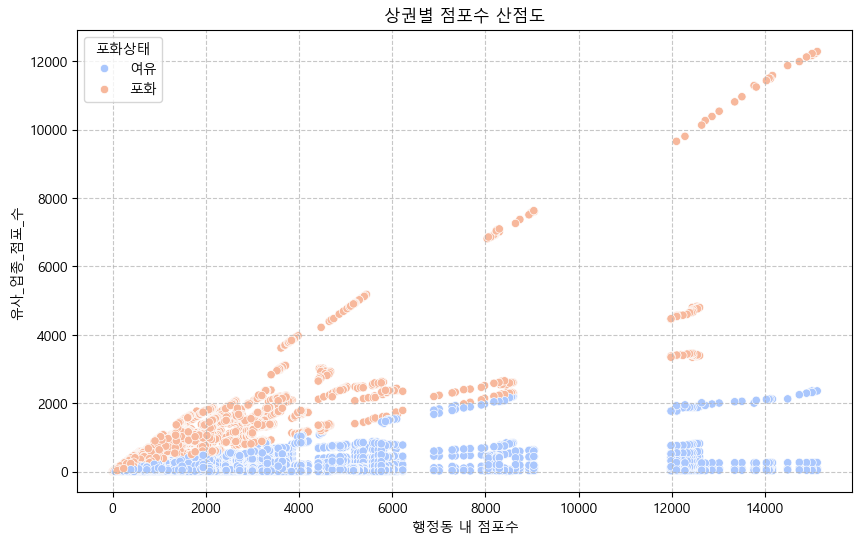

In [10]:
# 라벨링에 따라 점포수 분포 어떻게 되는지, 산점도로 확인. 
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data_label, x="행정동 내 점포수", y="유사_업종_점포_수", hue="포화상태", palette="coolwarm")
plt.xlabel("행정동 내 점포수")
plt.ylabel("유사_업종_점포_수")
plt.title("상권별 점포수 산점도")
plt.legend(title="포화상태")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Step02 가설 검정

## 가설 1 행정동 평균 점포수보다 점포수가 많으면, 해당 상권은 포화했을 것이다. 

### 데이터 준비 

In [25]:
data_hypo1 = data_label.copy()

In [26]:
# 기준_년분기_코드, 행정동 기준으로 점포수 평균 계산
avg_store_count = data_hypo1.groupby(["기준_년분기_코드", "행정동_코드_명"])['유사_업종_점포_수'].mean().reset_index()
avg_store_count.rename(columns = {'유사_업종_점포_수':'행정동 평균 점포수'}, inplace=True)
avg_store_count

# 라벨 데이터에 merge 
data_hypo1 = pd.merge(data_hypo1, avg_store_count, on=["기준_년분기_코드", "행정동_코드_명"], how='left')

# 평균 이상 / 이하 라벨링
data_hypo1['가설1_x'] = data_hypo1.apply(lambda row: '평균 이상' if row['유사_업종_점포_수'] > row['행정동 평균 점포수'] else '평균 이하', axis=1)

# 데이터 확인
data_hypo1

,기준_년분기_코드,상권_코드_명,행정동_코드_명,자치구_코드_명,유사_업종_점포_수,행정동 내 점포수,경쟁강도,포화상태,행정동 평균 점포수,가설1_x
0,20191,4.19민주묘지역 2번,우이동,강북구,34,282,0.120567,여유,47.000000,평균 이하
1,20191,63빌딩,여의동,영등포구,70,2909,0.024063,여유,969.666667,평균 이하
2,20191,DMC(디지털미디어시티),상암동,마포구,600,945,0.634921,포화,472.500000,평균 이상
3,20191,GS강동자이아파트,길동,강동구,101,1698,0.059482,여유,212.250000,평균 이하
4,20191,G타워,구로3동,구로구,26,2287,0.011369,여유,571.750000,평균 이하
...,...,...,...,...,...,...,...,...,...,...
33005,20242,효창동주민센터,효창동,용산구,29,102,0.284314,포화,51.000000,평균 이하
33006,20242,후암동주민센터,후암동,용산구,236,390,0.605128,포화,97.500000,평균 이상
33007,20242,후암시장,후암동,용산구,57,390,0.146154,여유,97.500000,평균 이하
33008,20242,휘문고교사거리,대치2동,강남구,80,1058,0.075614,여유,352.666667,평균 이하


### 시각화 

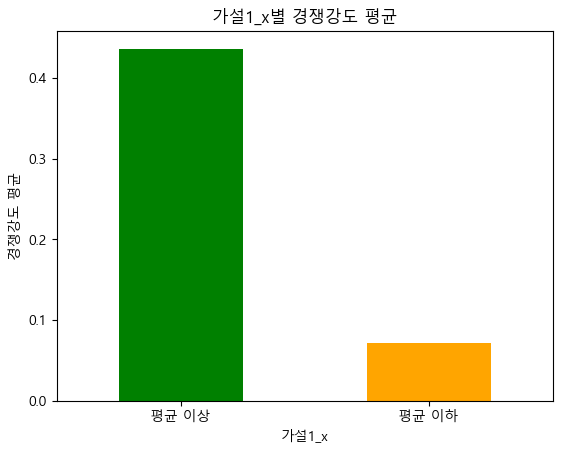

In [29]:
# 행정동 평균 점포수 이상, 이하 별로 경쟁강도 평균 계산
average_by_many_state = data_hypo1.groupby('가설1_x')['경쟁강도'].median()

# 막대그래프 그리기
average_by_many_state.plot(kind='bar', color=['green', 'orange', 'red'])

# 그래프 제목과 레이블 추가
plt.title('가설1_x별 경쟁강도 평균')
plt.xticks(rotation=0)
plt.xlabel('가설1_x')
plt.ylabel('경쟁강도 평균')

# 그래프 출력
plt.show()


### 통계분석

In [78]:
# 각 그룹별 경쟁강도 추출
many = data_hypo1[data_hypo1['가설1_x'] == '평균 이상']['경쟁강도']
less = data_hypo1[data_hypo1['가설1_x'] == '평균 이하']['경쟁강도']

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many)
less_normality = stats.shapiro(less)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("성장 상권 데이터는 정규분포를 따르지 않습니다.")
else:
    print("성장 상권 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("정체 상권 데이터는 정규분포를 따르지 않습니다.")
else:
    print("정체 상권 데이터는 정규분포를 따릅니다.")

many - p-value: 1.1388388232760317e-50
less - p-value: 2.4390269143307505e-114
성장 상권 데이터는 정규분포를 따르지 않습니다.
정체 상권 데이터는 정규분포를 따르지 않습니다.


c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12375.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20635.
  res = hypotest_fun_out(*samples, **kwds)


In [79]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many, less, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=232561027.5, p-value=0.0


In [80]:
from cliffs_delta import cliffs_delta

# Cliff's Delta 계산
delta, interpretation = cliffs_delta(many, less)

# 결과 출력
print(f"Cliff’s Delta: {delta:.3f}")
print(f"해석: {interpretation}")

Cliff’s Delta: 0.821
해석: large


In [34]:
# Fisher의 정확 검정 (평균 이상/이하 vs 포화/여유)
# 분할표 (Contingency Table) 생성
contingency_table = pd.crosstab(data_hypo1['가설1_x'], data_hypo1['포화상태'])

# Fisher의 정확 검정 수행
oddsratio, p_value = stats.fisher_exact(contingency_table)

print(f"Fisher의 정확 검정 결과: Odds Ratio={oddsratio}, p-value={p_value}")

Fisher의 정확 검정 결과: Odds Ratio=0.03341096927829647, p-value=0.0


In [84]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo1['유사_업종_점포_수'], data_hypo1['경쟁강도'])
print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")
# 스피어만 상관계수 
corr, p_value = spearmanr(data_hypo1['유사_업종_점포_수'], data_hypo1['경쟁강도'])
print(f"스피어만 상관분석 결과: 상관계수={corr}, p-value={p_value}")
# Hoeffding's D
corr, p_value = sign_test(data_hypo1['유사_업종_점포_수'], data_hypo1['경쟁강도'])
print(f"Hoeffding's D 상관분석 결과: 상관계수={corr}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=0.31338445078557825, p-value=0.0
스피어만 상관분석 결과: 상관계수=0.6582479871674903, p-value=0.0
Hoeffding's D 상관분석 결과: 상관계수=16505.0, p-value=0.0


### 통계분석(샘플링O)

In [36]:
# 각 그룹별 경쟁강도 추출
many = data_hypo1[data_hypo1['가설1_x'] == '평균 이상']['경쟁강도']
less = data_hypo1[data_hypo1['가설1_x'] == '평균 이하']['경쟁강도']

# 두 그룹의 최소 샘플 크기 찾기 / 300개 랜덤샘플링 
min_size = 300

# 랜덤 샘플링 (seed 설정으로 재현성 확보)
np.random.seed(42)
many_sampled = np.random.choice(many, size=min_size, replace=False)
less_sampled = np.random.choice(less, size=min_size, replace=False)

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many_sampled)
less_normality = stats.shapiro(less_sampled)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("성장 상권 데이터는 정규분포를 따르지 않습니다.")
else:
    print("성장 상권 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("정체 상권 데이터는 정규분포를 따르지 않습니다.")
else:
    print("정체 상권 데이터는 정규분포를 따릅니다.")

many - p-value: 8.027561030526265e-08
less - p-value: 4.97474139208356e-27
성장 상권 데이터는 정규분포를 따르지 않습니다.
정체 상권 데이터는 정규분포를 따르지 않습니다.


In [37]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many_sampled, less_sampled, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=80991.5, p-value=1.846606746148338e-64


## 가설 2 유동인구 대비 매출금액이 적은 상권은 포화 상태일 것이다. 

### 데이터 준비

In [48]:
data_hypo2 = data_label.copy()

In [49]:
# 상권 단위로 매출금액 sum + 유동인구 칼럼 붙이기
data_sale = data.groupby(['기준_년분기_코드','상권_코드_명'])['당월_매출_금액'].sum().reset_index()

data_hypo2 = pd.merge(data_hypo2, data_sale, on=['기준_년분기_코드','상권_코드_명'], how='left')
data_hypo2 = pd.merge(data_hypo2, data[['기준_년분기_코드','상권_코드_명','총_유동인구_수']], on=['기준_년분기_코드','상권_코드_명'], how='left')

# 중복되는 데이터 drop 
data_hypo2.drop_duplicates(inplace=True)

# 데이터 확인
data_hypo2.reset_index(inplace=True)
data_hypo2

,index,기준_년분기_코드,상권_코드_명,행정동_코드_명,자치구_코드_명,유사_업종_점포_수,행정동 내 점포수,경쟁강도,포화상태,당월_매출_금액,총_유동인구_수
0,0,20191,4.19민주묘지역 2번,우이동,강북구,34,282,0.120567,여유,2.712070e+08,522050
1,6,20191,63빌딩,여의동,영등포구,70,2909,0.024063,여유,1.993332e+08,57752
2,13,20191,DMC(디지털미디어시티),상암동,마포구,600,945,0.634921,포화,3.050783e+09,519877
3,42,20191,GS강동자이아파트,길동,강동구,101,1698,0.059482,여유,5.969977e+08,1049177
4,59,20191,G타워,구로3동,구로구,26,2287,0.011369,여유,2.236545e+08,351183
...,...,...,...,...,...,...,...,...,...,...,...
33005,445516,20242,효창동주민센터,효창동,용산구,29,102,0.284314,포화,2.075966e+08,1256249
33006,445522,20242,후암동주민센터,후암동,용산구,236,390,0.605128,포화,7.310171e+08,2083218
33007,445543,20242,후암시장,후암동,용산구,57,390,0.146154,여유,8.607352e+08,177952
33008,445556,20242,휘문고교사거리,대치2동,강남구,80,1058,0.075614,여유,8.225593e+09,336751


In [50]:
# 이상치를 조정할 칼럼 목록
cols = ['유사_업종_점포_수','총_유동인구_수','당월_매출_금액']

# 95번째 백분위수 기준으로 이상치 상한선 맞추기
for col in cols:
    upper_bound = data_hypo2[col].quantile(0.99)  # 95% 백분위수 계산
    data_hypo2[col] = np.where(data_hypo2[col] > upper_bound, upper_bound, data_hypo2[col])  # 초과값을 상한선으로 변경

In [51]:
# 유동인구 / 매출금액 칼럼 만들기. 
data_hypo2['가설2_x'] = data_hypo2['당월_매출_금액'] / data_hypo2['총_유동인구_수']

### 시각화 

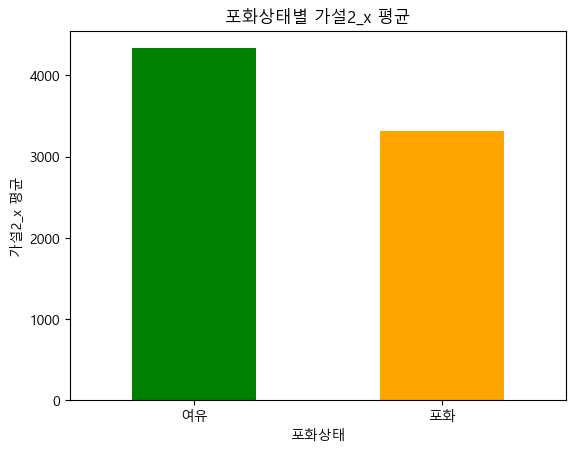

In [90]:
# 포화상태 별 유동인구/매출금액 평균 계산
average_by_many_state = data_hypo2.groupby('포화상태')['가설2_x'].mean()

# 막대그래프 그리기
average_by_many_state.plot(kind='bar', color=['green', 'orange', 'red'])

# 그래프 제목과 레이블 추가
plt.title('포화상태별 가설2_x 평균')
plt.xticks(rotation=0)
plt.xlabel('포화상태')
plt.ylabel('가설2_x 평균')

# 그래프 출력
plt.show()

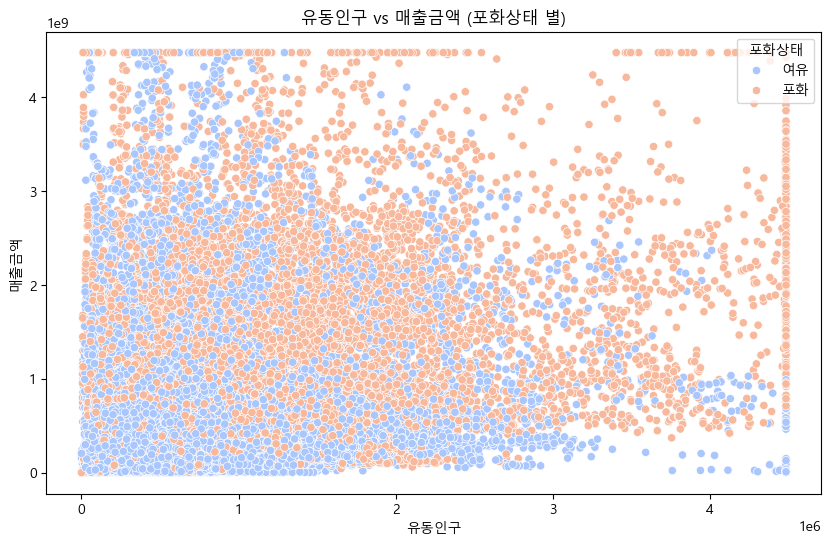

In [91]:
# 포화상태에 따라 색상 다르게 표시
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_hypo2, x='총_유동인구_수', y='당월_매출_금액', hue='포화상태', palette='coolwarm')
plt.title('유동인구 vs 매출금액 (포화상태 별)')
plt.xlabel('유동인구')
plt.ylabel('매출금액')
plt.legend(title='포화상태')
plt.show()

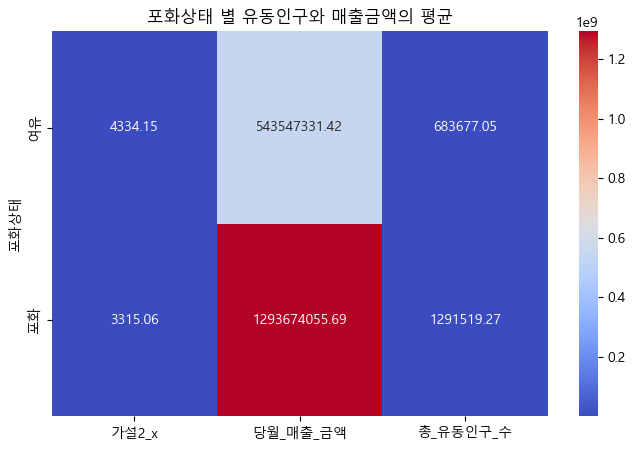

In [92]:
# 포화상태 별 유동인구와 매출금액의 평균 계산
pivot_table = data_hypo2.pivot_table(values=['총_유동인구_수', '당월_매출_금액','가설2_x'], index='포화상태', aggfunc='mean')

# 히트맵
plt.figure(figsize=(8, 5))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('포화상태 별 유동인구와 매출금액의 평균')
plt.show()

### 통계분석

In [93]:
# 각 그룹별 유동인구/매출 추출
many = data_hypo2[data_hypo2['포화상태'] == '포화']['가설2_x']
less = data_hypo2[data_hypo2['포화상태'] == '여유']['가설2_x']

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many)
less_normality = stats.shapiro(less)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 1.1281005300435091e-116
less - p-value: 9.580992359781916e-138
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11689.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21321.
  res = hypotest_fun_out(*samples, **kwds)


In [94]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many, less, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=153517666.0, p-value=4.911606659355795e-267


In [95]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo2['가설2_x'], data_hypo2['경쟁강도'])
print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")
# 스피어만 상관계수 
corr, p_value = spearmanr(data_hypo2['가설2_x'], data_hypo2['경쟁강도'])
print(f"스피어만 상관분석 결과: 상관계수={corr}, p-value={p_value}")
# Hoeffding's D
corr, p_value = sign_test(data_hypo2['가설2_x'], data_hypo2['경쟁강도'])
print(f"Hoeffding's D 상관분석 결과: 상관계수={corr}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=-0.0007978065124368103, p-value=0.8847541060233208
스피어만 상관분석 결과: 상관계수=0.2472618460863561, p-value=0.0
Hoeffding's D 상관분석 결과: 상관계수=16503.0, p-value=0.0


### 통계분석 (샘플링O)

In [76]:
# 각 그룹별 유동인구/매출 추출
many = data_hypo2[data_hypo2['포화상태'] == '포화']['가설2_x']
less = data_hypo2[data_hypo2['포화상태'] == '여유']['가설2_x']

# 두 그룹의 최소 샘플 크기 찾기 / 300개 랜덤샘플링 
min_size = 300

# 랜덤 샘플링 (seed 설정으로 재현성 확보)
np.random.seed(42)
many_sampled = np.random.choice(many, size=min_size, replace=False)
less_sampled = np.random.choice(less, size=min_size, replace=False)

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many_sampled)
less_normality = stats.shapiro(less_sampled)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 3.106779087724628e-28
less - p-value: 3.2309932227718435e-32
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


In [77]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many_sampled, less_sampled, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=55639.0, p-value=5.41864778547916e-07


In [ ]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo2['가설2_x'], data_hypo2['경쟁강도'])

print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=-0.0007978065124368103, p-value=0.8847541060233208


## 가설 3 상권 내에 업종이 다양하면, 포화 상태일 것이다. 

### 데이터 준비

In [97]:
data_hypo3 = data_label.copy()

In [98]:
# 상권 내 서비스 업종 종류 수 구하기
data['업종다양성'] = data.groupby(['기준_년분기_코드', '상권_코드_명'])['서비스_업종_코드_명'].transform('nunique')

In [99]:
# 업종다양성 붙이기
data_hypo3 = pd.merge(data_hypo3, data[['기준_년분기_코드','상권_코드_명','업종다양성']], on=['기준_년분기_코드','상권_코드_명'], how='left')

# 중복되는 데이터 drop 
data_hypo3.drop_duplicates(inplace=True)

# 데이터 확인
data_hypo3.reset_index(inplace=True)
data_hypo3.drop(columns='index',inplace=True)
data_hypo3

,기준_년분기_코드,상권_코드_명,행정동_코드_명,자치구_코드_명,유사_업종_점포_수,행정동 내 점포수,경쟁강도,포화상태,업종다양성
0,20191,4.19민주묘지역 2번,우이동,강북구,34,282,0.120567,여유,6
1,20191,63빌딩,여의동,영등포구,70,2909,0.024063,여유,7
2,20191,DMC(디지털미디어시티),상암동,마포구,600,945,0.634921,포화,29
3,20191,GS강동자이아파트,길동,강동구,101,1698,0.059482,여유,17
4,20191,G타워,구로3동,구로구,26,2287,0.011369,여유,4
...,...,...,...,...,...,...,...,...,...
33005,20242,효창동주민센터,효창동,용산구,29,102,0.284314,포화,6
33006,20242,후암동주민센터,후암동,용산구,236,390,0.605128,포화,21
33007,20242,후암시장,후암동,용산구,57,390,0.146154,여유,13
33008,20242,휘문고교사거리,대치2동,강남구,80,1058,0.075614,여유,13


In [100]:
# 이상치를 조정할 칼럼 목록
cols = ['유사_업종_점포_수']

# 95번째 백분위수 기준으로 이상치 상한선 맞추기
for col in cols:
    upper_bound = data_hypo3[col].quantile(0.99)  # 95% 백분위수 계산
    data_hypo3[col] = np.where(data_hypo3[col] > upper_bound, upper_bound, data_hypo3[col])  # 초과값을 상한선으로 변경

### 시각화 

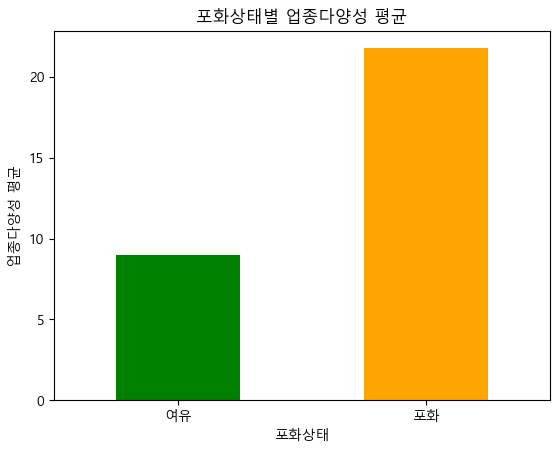

In [31]:
# 포화상태 별 업종다양성 컬럼의 평균 계산
average_by_many_state = data_hypo3.groupby('포화상태')['업종다양성'].mean()

# 막대그래프 그리기
average_by_many_state.plot(kind='bar', color=['green', 'orange', 'red'])

# 그래프 제목과 레이블 추가
plt.title('포화상태별 업종다양성 평균')
plt.xticks(rotation=0)
plt.xlabel('포화상태')
plt.ylabel('업종다양성 평균')

# 그래프 출력
plt.show()

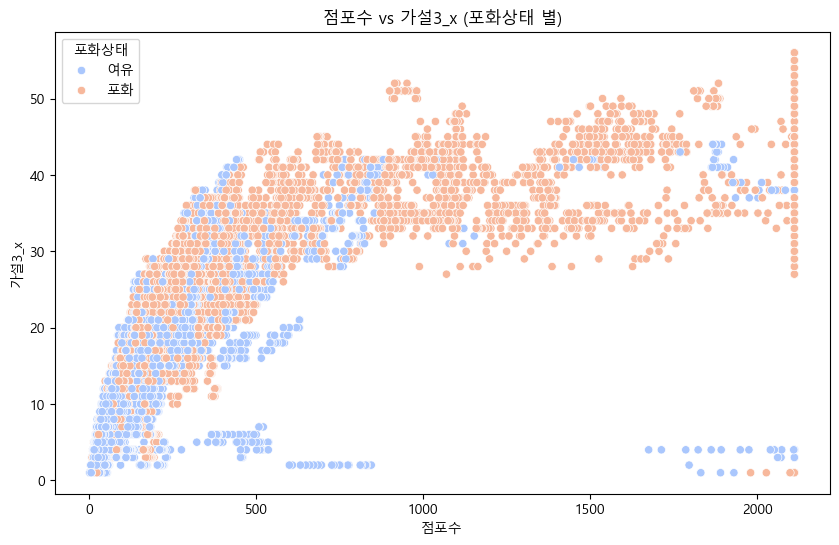

In [32]:
# 포화상태에 따라 색상 다르게 표시
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_hypo3, x='유사_업종_점포_수', y='업종다양성', hue='포화상태', palette='coolwarm')
plt.title('점포수 vs 가설3_x (포화상태 별)')
plt.xlabel('점포수')
plt.ylabel('가설3_x')
plt.legend(title='포화상태')
plt.show()

### 통계분석

In [101]:
# 각 그룹별 업종다양성 추출
many = data_hypo3[data_hypo3['포화상태'] == '포화']['업종다양성']
less = data_hypo3[data_hypo3['포화상태'] == '여유']['업종다양성']

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many)
less_normality = stats.shapiro(less)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 3.829008403373738e-42
less - p-value: 1.0579003542927134e-87
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11689.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21321.
  res = hypotest_fun_out(*samples, **kwds)


In [102]:
# Mann-Whitney U 검정 실행
u_stat, p_value = stats.mannwhitneyu(many, less, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=207769452.0, p-value=0.0


In [103]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo3['업종다양성'], data_hypo3['경쟁강도'])
print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")
# 스피어만 상관계수 
corr, p_value = spearmanr(data_hypo3['업종다양성'], data_hypo3['경쟁강도'])
print(f"스피어만 상관분석 결과: 상관계수={corr}, p-value={p_value}")
# Hoeffding's D
corr, p_value = sign_test(data_hypo3['업종다양성'], data_hypo3['경쟁강도'])
print(f"Hoeffding's D 상관분석 결과: 상관계수={corr}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=0.5554433415762733, p-value=0.0
스피어만 상관분석 결과: 상관계수=0.6758059424435878, p-value=0.0
Hoeffding's D 상관분석 결과: 상관계수=16484.0, p-value=0.0


### 통계분석(샘플링O)

In [78]:
# 각 그룹별 업종다양성 추출
many = data_hypo3[data_hypo3['포화상태'] == '포화']['업종다양성']
less = data_hypo3[data_hypo3['포화상태'] == '여유']['업종다양성']

# 두 그룹의 최소 샘플 크기 찾기 / 300개 랜덤샘플링 
min_size = 300

# 랜덤 샘플링 (seed 설정으로 재현성 확보)
np.random.seed(42)
many_sampled = np.random.choice(many, size=min_size, replace=False)
less_sampled = np.random.choice(less, size=min_size, replace=False)

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many_sampled)
less_normality = stats.shapiro(less_sampled)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 5.6589807175889654e-08
less - p-value: 3.006147298209247e-15
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


In [82]:
# Mann-Whitney U 검정 실행
u_stat, p_value = stats.mannwhitneyu(many_sampled, less_sampled, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=73393.0, p-value=7.85540748907164e-41


In [ ]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo3['업종다양성'], data_hypo3['경쟁강도'])

print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=0.5554433415762733, p-value=0.0


## 가설 4 전분기 대비 점포수가 늘어난 경우가 잦다면, 포화 상태일 것이다.

### 데이터 준비

In [104]:
data_hypo4 = data_label.copy()

In [105]:
# 기준년분기&상권 기준 정렬
data_hypo4 = data_hypo4.sort_values(['상권_코드_명','기준_년분기_코드'])

# 기준년분기코드 기준으로 저눈기 대비 점포수가 증가한 경우에 1/0 부여하기
data_hypo4['전분기_점포수'] = data_hypo4.groupby('상권_코드_명')['유사_업종_점포_수'].shift(1) 
data_hypo4['점포수 증가'] = (data_hypo4['유사_업종_점포_수'] > data_hypo4['전분기_점포수']).astype(int)

# 20242 까지의 점수 합산
data_hypo4['개업 점수'] = data_hypo4.groupby('상권_코드_명')['점포수 증가'].cumsum()

# 데이터 확인
data_hypo4.reset_index(inplace=True)
data_hypo4.drop(columns='index',inplace=True)
data_hypo4

,기준_년분기_코드,상권_코드_명,행정동_코드_명,자치구_코드_명,유사_업종_점포_수,행정동 내 점포수,경쟁강도,포화상태,전분기_점포수,점포수 증가,개업 점수
0,20191,4.19민주묘지역 2번,우이동,강북구,34,282,0.120567,여유,NaN,0,0
1,20192,4.19민주묘지역 2번,우이동,강북구,35,283,0.123675,여유,34.0,1,1
2,20193,4.19민주묘지역 2번,우이동,강북구,31,272,0.113971,여유,35.0,0,1
3,20194,4.19민주묘지역 2번,우이동,강북구,33,258,0.127907,여유,31.0,1,2
4,20201,4.19민주묘지역 2번,우이동,강북구,38,276,0.137681,여유,33.0,1,3
...,...,...,...,...,...,...,...,...,...,...,...
33005,20232,흑리단길,흑석동,동작구,89,239,0.372385,포화,87.0,1,5
33006,20233,흑리단길,흑석동,동작구,85,232,0.366379,포화,89.0,0,5
33007,20234,흑리단길,흑석동,동작구,88,231,0.380952,포화,85.0,1,6
33008,20241,흑리단길,흑석동,동작구,90,235,0.382979,포화,88.0,1,7


### 시각화 

Text(0.5, 1.0, '포화상태에 따른 개업 점수 밀도')

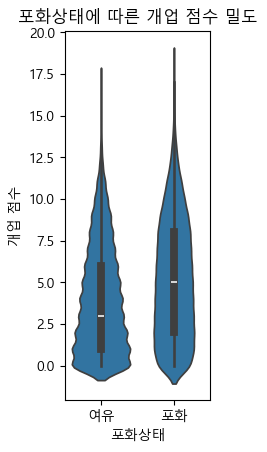

In [38]:
plt.subplot(1, 3, 1)
sns.violinplot(data=data_hypo4, x='포화상태', y='개업 점수')
plt.title('포화상태에 따른 개업 점수 밀도')

### 통계분석

In [39]:
# 각 그룹별 개업점수 추출
many = data_hypo4[data_hypo4['포화상태'] == '포화']['개업 점수']
less = data_hypo4[data_hypo4['포화상태'] == '여유']['개업 점수']

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many)
less_normality = stats.shapiro(less)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 8.316314469927106e-49
less - p-value: 7.373956486867577e-70
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11689.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21321.
  res = hypotest_fun_out(*samples, **kwds)


In [40]:
# Mann-Whitney U 검정 실행
u_stat, p_value = stats.mannwhitneyu(many, less, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=148474891.0, p-value=2.5493442523641933e-184


In [107]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo4['개업 점수'], data_hypo4['경쟁강도'])
print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")
# 스피어만 상관계수 
corr, p_value = spearmanr(data_hypo4['개업 점수'], data_hypo4['경쟁강도'])
print(f"스피어만 상관분석 결과: 상관계수={corr}, p-value={p_value}")
# Hoeffding's D
corr, p_value = sign_test(data_hypo4['개업 점수'], data_hypo4['경쟁강도'])
print(f"Hoeffding's D 상관분석 결과: 상관계수={corr}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=0.17040255398432919, p-value=1.597833093147266e-213
스피어만 상관분석 결과: 상관계수=0.23824766267059178, p-value=0.0
Hoeffding's D 상관분석 결과: 상관계수=12433.5, p-value=0.0


### 통계분석 (샘플링O)

In [83]:
# 각 그룹별 개업점수 추출
many = data_hypo4[data_hypo4['포화상태'] == '포화']['개업 점수']
less = data_hypo4[data_hypo4['포화상태'] == '여유']['개업 점수']

# 두 그룹의 최소 샘플 크기 찾기 / 300개 랜덤샘플링 
min_size = 300

# 랜덤 샘플링 (seed 설정으로 재현성 확보)
np.random.seed(42)
many_sampled = np.random.choice(many, size=min_size, replace=False)
less_sampled = np.random.choice(less, size=min_size, replace=False)

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many_sampled)
less_normality = stats.shapiro(less_sampled)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 7.936473387728873e-08
less - p-value: 1.0709088371345538e-10
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


In [84]:
# Mann-Whitney U 검정 실행
u_stat, p_value = stats.mannwhitneyu(many_sampled, less_sampled, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=54720.0, p-value=4.251779678693729e-06


In [ ]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo4['개업 점수'], data_hypo4['경쟁강도'])

print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=0.17040255398432919, p-value=1.597833093147266e-213


## 가설 5 유동인구 대비 점포가 많은 상권은, 포화 상태일 것이다. 

### 데이터 준비

In [108]:
data_hypo5 = data_label.copy()

In [109]:
# 상권 단위로 유동인구 칼럼 붙이기
data_hypo5 = pd.merge(data_hypo5, data[['기준_년분기_코드','상권_코드_명','총_유동인구_수']], on=['기준_년분기_코드','상권_코드_명'], how='left')

# 중복되는 데이터 drop 
data_hypo5.drop_duplicates(inplace=True)

# 데이터 확인
data_hypo5 = data_hypo5.reset_index(drop=True)
data_hypo5

,기준_년분기_코드,상권_코드_명,행정동_코드_명,자치구_코드_명,유사_업종_점포_수,행정동 내 점포수,경쟁강도,포화상태,총_유동인구_수
0,20191,4.19민주묘지역 2번,우이동,강북구,34,282,0.120567,여유,522050
1,20191,63빌딩,여의동,영등포구,70,2909,0.024063,여유,57752
2,20191,DMC(디지털미디어시티),상암동,마포구,600,945,0.634921,포화,519877
3,20191,GS강동자이아파트,길동,강동구,101,1698,0.059482,여유,1049177
4,20191,G타워,구로3동,구로구,26,2287,0.011369,여유,351183
...,...,...,...,...,...,...,...,...,...
33005,20242,효창동주민센터,효창동,용산구,29,102,0.284314,포화,1256249
33006,20242,후암동주민센터,후암동,용산구,236,390,0.605128,포화,2083218
33007,20242,후암시장,후암동,용산구,57,390,0.146154,여유,177952
33008,20242,휘문고교사거리,대치2동,강남구,80,1058,0.075614,여유,336751


In [110]:
# 유동인구 / 점포 수 
data_hypo5['가설5_x'] = data_hypo5['총_유동인구_수'] / data_hypo5['유사_업종_점포_수']
data_hypo5['가설5_x_log'] = np.log(data_hypo5['가설5_x'])

### 시각화 

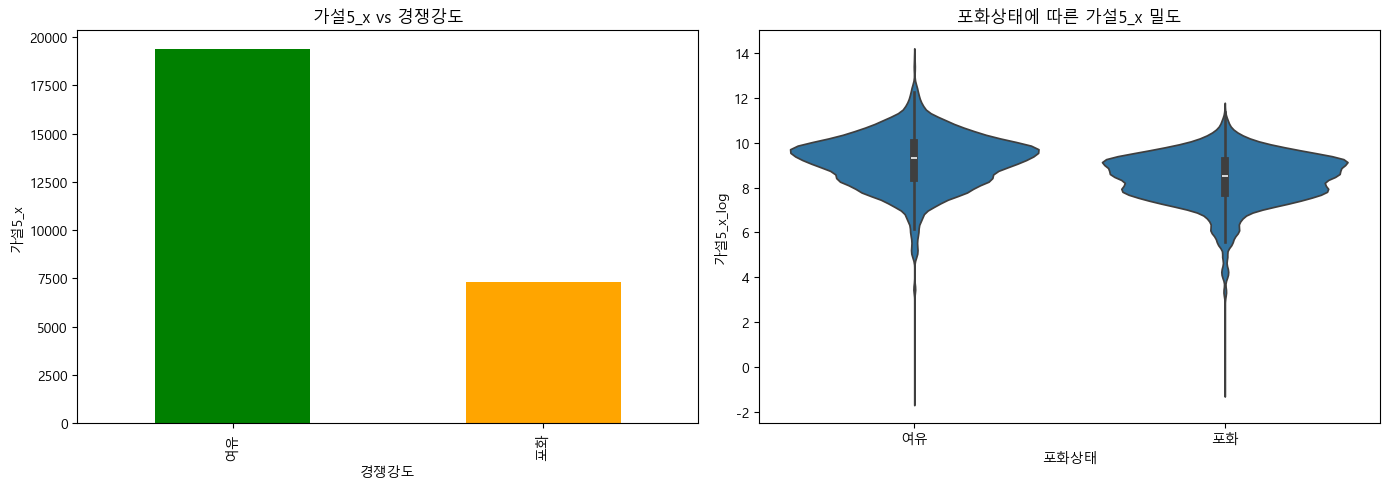

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 5))  # 전체 figure 크기 설정

# 가설5_x vs 경쟁강도 산점도
plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째 그래프
# 포화상태별로 가설5_x 컬럼의 평균 계산
average_by_many_state = data_hypo5.groupby('포화상태')['가설5_x'].mean()

# 막대그래프 그리기
average_by_many_state.plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('가설5_x vs 경쟁강도')
plt.xlabel('경쟁강도')
plt.ylabel('가설5_x')

# 포화상태별로 가설5_x 밀도 (바이올린 플롯)
plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째 그래프
sns.violinplot(data=data_hypo5, x='포화상태', y='가설5_x_log')
plt.title('포화상태에 따른 가설5_x 밀도')

plt.tight_layout()  # 그래프 간격 자동 조정
plt.show()


### 통계분석

In [48]:
# 각 그룹별 가설5_x 추출
many = data_hypo5[data_hypo5['포화상태'] == '포화']['가설5_x']
less = data_hypo5[data_hypo5['포화상태'] == '여유']['가설5_x']

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many)
less_normality = stats.shapiro(less)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 3.35952488953496e-85
less - p-value: 3.518374530772422e-124
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11689.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21321.
  res = hypotest_fun_out(*samples, **kwds)


In [49]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many, less, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=75081659.0, p-value=0.0


In [111]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo5['가설5_x'], data_hypo5['경쟁강도'])
print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")
# 스피어만 상관계수 
corr, p_value = spearmanr(data_hypo5['가설5_x'], data_hypo5['경쟁강도'])
print(f"스피어만 상관분석 결과: 상관계수={corr}, p-value={p_value}")
# Hoeffding's D
corr, p_value = sign_test(data_hypo5['가설5_x'], data_hypo5['경쟁강도'])
print(f"Hoeffding's D 상관분석 결과: 상관계수={corr}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=-0.20455594627719434, p-value=9.14990622757431e-309
스피어만 상관분석 결과: 상관계수=-0.4114596003359413, p-value=0.0
Hoeffding's D 상관분석 결과: 상관계수=16504.0, p-value=0.0


### 통계분석 (샘플링O)

In [85]:
# 각 그룹별 가설5_x 추출
many = data_hypo5[data_hypo5['포화상태'] == '포화']['가설5_x']
less = data_hypo5[data_hypo5['포화상태'] == '여유']['가설5_x']

# 두 그룹의 최소 샘플 크기 찾기 / 300개 랜덤샘플링 
min_size = 300

# 랜덤 샘플링 (seed 설정으로 재현성 확보)
np.random.seed(42)
many_sampled = np.random.choice(many, size=min_size, replace=False)
less_sampled = np.random.choice(less, size=min_size, replace=False)

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many_sampled)
less_normality = stats.shapiro(less_sampled)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 1.0690373657416167e-21
less - p-value: 7.0281994824417605e-34
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


In [86]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many_sampled, less_sampled, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=27168.0, p-value=4.508585632227692e-17


In [ ]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo5['가설5_x'], data_hypo5['경쟁강도'])

print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=-0.20455594627719434, p-value=9.14990622757431e-309


## 가설 6 30~50대 유동인구가 많은 지역은 포화 상권일 것이다. 

### 데이터 준비

In [11]:
data_hypo6 = data_label.copy()

In [12]:
# 유동인구 칼럼 붙이기
data_hypo6 = pd.merge(data_hypo6, 
                      data[['기준_년분기_코드','상권_코드_명','연령대_30_유동인구_수','연령대_40_유동인구_수','연령대_50_유동인구_수']], 
                      on=['기준_년분기_코드','상권_코드_명'], how='left')

# 중복되는 데이터 drop 
data_hypo6.drop_duplicates(inplace=True)

# 데이터 확인
data_hypo6.reset_index(inplace=True)
data_hypo6.drop(columns='index',inplace=True)
data_hypo6

,기준_년분기_코드,상권_코드_명,행정동_코드_명,자치구_코드_명,유사_업종_점포_수,행정동 내 점포수,경쟁강도,포화상태,연령대_30_유동인구_수,연령대_40_유동인구_수,연령대_50_유동인구_수
0,20191,4.19민주묘지역 2번,우이동,강북구,34,282,0.120567,여유,58675,73914,75159
1,20191,63빌딩,여의동,영등포구,70,2909,0.024063,여유,11893,10901,7462
2,20191,DMC(디지털미디어시티),상암동,마포구,600,945,0.634921,포화,136415,109519,54057
3,20191,GS강동자이아파트,길동,강동구,101,1698,0.059482,여유,135222,159368,158022
4,20191,G타워,구로3동,구로구,26,2287,0.011369,여유,108576,56150,34563
...,...,...,...,...,...,...,...,...,...,...,...
33005,20242,효창동주민센터,효창동,용산구,29,102,0.284314,포화,226637,219956,165995
33006,20242,후암동주민센터,후암동,용산구,236,390,0.605128,포화,412109,351618,296956
33007,20242,후암시장,후암동,용산구,57,390,0.146154,여유,33730,29655,29783
33008,20242,휘문고교사거리,대치2동,강남구,80,1058,0.075614,여유,80729,72592,40618


In [13]:
# 점포 수 / 업종다양성
data_hypo6['가설6_x'] = data_hypo6['연령대_30_유동인구_수'] + data_hypo6['연령대_40_유동인구_수'] + data_hypo6['연령대_50_유동인구_수']

### 시각화 

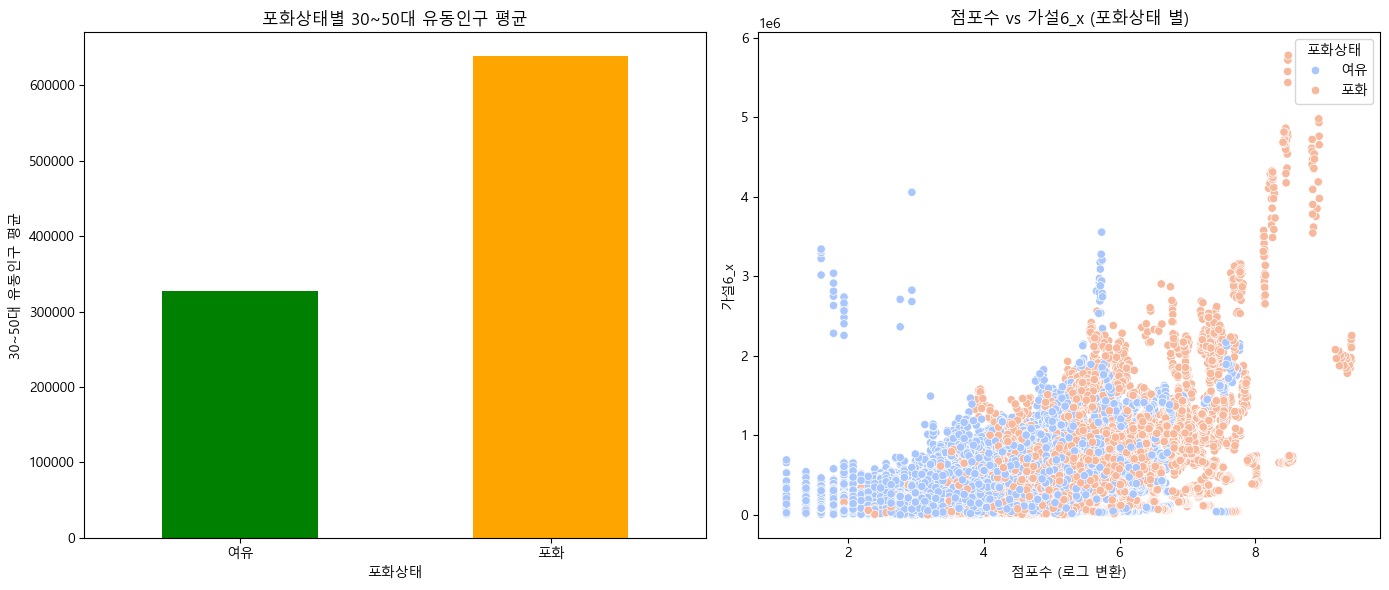

In [54]:
# 피겨 사이즈 설정
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 가로로 2개 배치

# 첫 번째 그래프: 포화상태별 30~50대 유동인구 평균 막대 그래프
average_by_many_state = data_hypo6.groupby('포화상태')['가설6_x'].mean()
average_by_many_state.plot(kind='bar', color=['green', 'orange', 'red'], ax=axes[0])

# 제목 및 레이블 설정
axes[0].set_title('포화상태별 30~50대 유동인구 평균')
axes[0].set_xlabel('포화상태')
axes[0].set_ylabel('30~50대 유동인구 평균')
axes[0].tick_params(axis='x', rotation=0)  # X축 레이블 회전 제거

# 두 번째 그래프: 점포수 vs 가설6_x (포화상태 별) 산점도
data_hypo6['유사_업종_점포_수_log'] = np.log(data_hypo6['유사_업종_점포_수'])
sns.scatterplot(data=data_hypo6, x='유사_업종_점포_수_log', y='가설6_x', hue='포화상태', palette='coolwarm', ax=axes[1])

# 제목 및 레이블 설정
axes[1].set_title('점포수 vs 가설6_x (포화상태 별)')
axes[1].set_xlabel('점포수 (로그 변환)')
axes[1].set_ylabel('가설6_x')
axes[1].legend(title='포화상태')

# 그래프 출력
plt.tight_layout()  # 레이아웃 조정
plt.show()


### 통계분석

In [55]:
# 각 그룹별 가설6_x(30~50대 유동인구 수 sum) 추출
many = data_hypo6[data_hypo6['포화상태'] == '포화']['가설6_x']
less = data_hypo6[data_hypo6['포화상태'] == '여유']['가설6_x']

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many)
less_normality = stats.shapiro(less)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 2.678035125576887e-81
less - p-value: 2.1734102701696225e-96
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11689.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21321.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many, less, alternative='two-sided')

# Mann-Whitney U 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=175815098.0, p-value=0.0


In [15]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo6['가설6_x'], data_hypo6['경쟁강도'])
print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")
# 스피어만 상관계수 
corr, p_value = spearmanr(data_hypo6['가설6_x'], data_hypo6['경쟁강도'])
print(f"스피어만 상관분석 결과: 상관계수={corr}, p-value={p_value}")
# Hoeffding's D
corr, p_value = sign_test(data_hypo6['가설6_x'], data_hypo6['경쟁강도'])
print(f"Hoeffding's D 상관분석 결과: 상관계수={corr}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=0.31735615094562997, p-value=0.0
스피어만 상관분석 결과: 상관계수=0.41954033299397064, p-value=0.0
Hoeffding's D 상관분석 결과: 상관계수=16501.0, p-value=0.0


### 통계분석(샘플링O)

In [87]:
# 각 그룹별 가설6_x(30~50대 유동인구 수 sum) 추출
many = data_hypo6[data_hypo6['포화상태'] == '포화']['가설6_x']
less = data_hypo6[data_hypo6['포화상태'] == '여유']['가설6_x']

# 두 그룹의 최소 샘플 크기 찾기 / 300개 랜덤샘플링 
min_size = 300

# 랜덤 샘플링 (seed 설정으로 재현성 확보)
np.random.seed(42)
many_sampled = np.random.choice(many, size=min_size, replace=False)
less_sampled = np.random.choice(less, size=min_size, replace=False)

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many_sampled)
less_normality = stats.shapiro(less_sampled)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 6.161393961250222e-18
less - p-value: 1.0724630014746256e-20
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


In [88]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many_sampled, less_sampled, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=59407.5, p-value=1.1538703294409363e-11


In [ ]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo6['가설6_x'], data_hypo6['경쟁강도'])

print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=0.31735615094562997, p-value=0.0


## 가설 7 집객시설이 많은 상권은 포화상태일 것이다. 

### 데이터 준비

In [16]:
data_hypo7 = data_label.copy()

In [17]:
# 집객시설 종류별 sum + merge 
data_venue = data[['기준_년분기_코드','상권_코드_명','집객시설_수','관공서_수','은행_수','종합병원_수','일반_병원_수','약국_수','유치원_수',
                   '초등학교_수','중학교_수','고등학교_수','대학교_수','백화점_수','슈퍼마켓_수','극장_수','숙박_시설_수',
                   '공항_수','철도_역_수','버스_터미널_수','지하철_역_수','버스_정거장_수']]
data_hypo7 = pd.merge(data_hypo7, data_venue, on=['기준_년분기_코드','상권_코드_명'], how='left')

# 중복되는 데이터 drop 
data_hypo7.drop_duplicates(inplace=True)

# 데이터 확인
data_hypo7.reset_index(inplace=True)
data_hypo7.drop(columns='index',inplace=True)
data_hypo7

,기준_년분기_코드,상권_코드_명,행정동_코드_명,자치구_코드_명,유사_업종_점포_수,행정동 내 점포수,경쟁강도,포화상태,집객시설_수,관공서_수,...,대학교_수,백화점_수,슈퍼마켓_수,극장_수,숙박_시설_수,공항_수,철도_역_수,버스_터미널_수,지하철_역_수,버스_정거장_수
0,20191,4.19민주묘지역 2번,우이동,강북구,34,282,0.120567,여유,12,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,20191,63빌딩,여의동,영등포구,70,2909,0.024063,여유,7,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20191,DMC(디지털미디어시티),상암동,마포구,600,945,0.634921,포화,79,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0
3,20191,GS강동자이아파트,길동,강동구,101,1698,0.059482,여유,10,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,20191,G타워,구로3동,구로구,26,2287,0.011369,여유,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33005,20242,효창동주민센터,효창동,용산구,29,102,0.284314,포화,19,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
33006,20242,후암동주민센터,후암동,용산구,236,390,0.605128,포화,30,3.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
33007,20242,후암시장,후암동,용산구,57,390,0.146154,여유,11,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
33008,20242,휘문고교사거리,대치2동,강남구,80,1058,0.075614,여유,12,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0


In [18]:
# 집객시설 수 sum
columns_to_sum = ['집객시설_수','관공서_수','은행_수','종합병원_수','일반_병원_수','약국_수','유치원_수',
                  '초등학교_수','중학교_수','고등학교_수','대학교_수','백화점_수','슈퍼마켓_수','극장_수',
                  '숙박_시설_수','공항_수','철도_역_수','버스_터미널_수','지하철_역_수','버스_정거장_수']

# 새로운 칼럼 추가 (집객시설 총합)
data_hypo7['가설7_x'] = data_hypo7[columns_to_sum].sum(axis=1)

### 시각화 

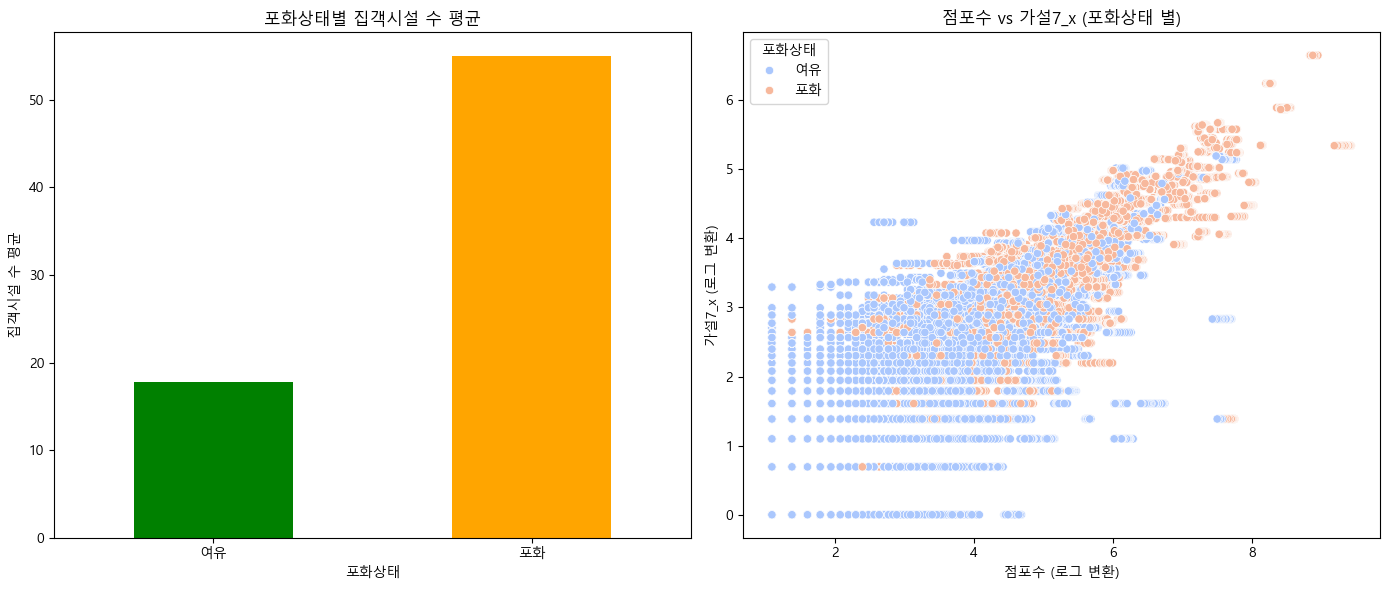

In [61]:
# 피겨 사이즈 설정
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 가로로 2개 배치

# 첫 번째 그래프: 포화상태별 집객시설 수 평균 막대 그래프
average_by_many_state = data_hypo7.groupby('포화상태')['가설7_x'].mean()
average_by_many_state.plot(kind='bar', color=['green', 'orange', 'red'], ax=axes[0])

# 제목 및 레이블 설정
axes[0].set_title('포화상태별 집객시설 수 평균')
axes[0].set_xlabel('포화상태')
axes[0].set_ylabel('집객시설 수 평균')
axes[0].tick_params(axis='x', rotation=0)  # X축 레이블 회전 제거

# 로그 변환 추가
data_hypo7['유사_업종_점포_수_log'] = np.log(data_hypo7['유사_업종_점포_수'])
data_hypo7['가설7_x_log'] = np.log(data_hypo7['가설7_x'])

# 두 번째 그래프: 점포수 vs 가설7_x (포화상태 별) 산점도
sns.scatterplot(data=data_hypo7, x='유사_업종_점포_수_log', y='가설7_x_log', hue='포화상태', palette='coolwarm', ax=axes[1])

# 제목 및 레이블 설정
axes[1].set_title('점포수 vs 가설7_x (포화상태 별)')
axes[1].set_xlabel('점포수 (로그 변환)')
axes[1].set_ylabel('가설7_x (로그 변환)')
axes[1].legend(title='포화상태')

# 그래프 출력
plt.tight_layout()  # 레이아웃 조정
plt.show()


### 통계분석

In [62]:
# 각 그룹별 가설7_x 추출
many = data_hypo7[data_hypo7['포화상태'] == '포화']['가설7_x']
less = data_hypo7[data_hypo7['포화상태'] == '여유']['가설7_x']

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many)
less_normality = stats.shapiro(less)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 3.6308759136266375e-95
less - p-value: 1.1154267812224057e-105
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11689.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21321.
  res = hypotest_fun_out(*samples, **kwds)


In [63]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many, less, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=202829107.0, p-value=0.0


In [19]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo7['가설7_x'], data_hypo7['경쟁강도'])
print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")
# 스피어만 상관계수 
corr, p_value = spearmanr(data_hypo7['가설7_x'], data_hypo7['경쟁강도'])
print(f"스피어만 상관분석 결과: 상관계수={corr}, p-value={p_value}")
# Hoeffding's D
corr, p_value = sign_test(data_hypo7['가설7_x'], data_hypo7['경쟁강도'])
print(f"Hoeffding's D 상관분석 결과: 상관계수={corr}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=0.4261459345679769, p-value=0.0
스피어만 상관분석 결과: 상관계수=0.6360916661343644, p-value=0.0
Hoeffding's D 상관분석 결과: 상관계수=16495.0, p-value=0.0


### 통계분석 (샘플링O)

In [89]:
# 각 그룹별 가설7_x 추출
many = data_hypo7[data_hypo7['포화상태'] == '포화']['가설7_x']
less = data_hypo7[data_hypo7['포화상태'] == '여유']['가설7_x']

# 두 그룹의 최소 샘플 크기 찾기 / 300개 랜덤샘플링 
min_size = 300

# 랜덤 샘플링 (seed 설정으로 재현성 확보)
np.random.seed(42)
many_sampled = np.random.choice(many, size=min_size, replace=False)
less_sampled = np.random.choice(less, size=min_size, replace=False)

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many_sampled)
less_normality = stats.shapiro(less_sampled)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 1.0106971551168035e-22
less - p-value: 1.6589608644352675e-22
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


In [90]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many_sampled, less_sampled, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=71816.5, p-value=1.3824871630944906e-36


In [ ]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo7['가설7_x'], data_hypo7['경쟁강도'])

print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=0.4261459345679769, p-value=0.0


## 가설 8 집객시설 종류가 다양한 상권은 포화 상태일 것이다.  

### 데이터 준비

In [20]:
data_hypo8 = data_label.copy()

In [21]:
# 집객시설 종류별 merge
data_venue = data[['기준_년분기_코드','상권_코드_명','집객시설_수','관공서_수','은행_수','종합병원_수','일반_병원_수','약국_수','유치원_수',
                   '초등학교_수','중학교_수','고등학교_수','대학교_수','백화점_수','슈퍼마켓_수','극장_수','숙박_시설_수',
                   '공항_수','철도_역_수','버스_터미널_수','지하철_역_수','버스_정거장_수']]
data_hypo8 = pd.merge(data_hypo8, data_venue, on=['기준_년분기_코드','상권_코드_명'], how='left')

# 중복되는 데이터 drop 
data_hypo8.drop_duplicates(inplace=True)

# 데이터 확인
data_hypo8.reset_index(inplace=True)
data_hypo8.drop(columns='index',inplace=True)
data_hypo8

,기준_년분기_코드,상권_코드_명,행정동_코드_명,자치구_코드_명,유사_업종_점포_수,행정동 내 점포수,경쟁강도,포화상태,집객시설_수,관공서_수,...,대학교_수,백화점_수,슈퍼마켓_수,극장_수,숙박_시설_수,공항_수,철도_역_수,버스_터미널_수,지하철_역_수,버스_정거장_수
0,20191,4.19민주묘지역 2번,우이동,강북구,34,282,0.120567,여유,12,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,20191,63빌딩,여의동,영등포구,70,2909,0.024063,여유,7,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20191,DMC(디지털미디어시티),상암동,마포구,600,945,0.634921,포화,79,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0
3,20191,GS강동자이아파트,길동,강동구,101,1698,0.059482,여유,10,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,20191,G타워,구로3동,구로구,26,2287,0.011369,여유,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33005,20242,효창동주민센터,효창동,용산구,29,102,0.284314,포화,19,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
33006,20242,후암동주민센터,후암동,용산구,236,390,0.605128,포화,30,3.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
33007,20242,후암시장,후암동,용산구,57,390,0.146154,여유,11,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
33008,20242,휘문고교사거리,대치2동,강남구,80,1058,0.075614,여유,12,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0


In [22]:
# 집객시설 수 count
columns_to_count = ['집객시설_수','관공서_수','은행_수','종합병원_수','일반_병원_수','약국_수','유치원_수',
                  '초등학교_수','중학교_수','고등학교_수','대학교_수','백화점_수','슈퍼마켓_수','극장_수',
                  '숙박_시설_수','공항_수','철도_역_수','버스_터미널_수','지하철_역_수','버스_정거장_수']

# 새로운 칼럼 추가 (집객시설 총합)
data_hypo8['가설8_x'] = (data[columns_to_count] > 0).sum(axis=1)

### 시각화 

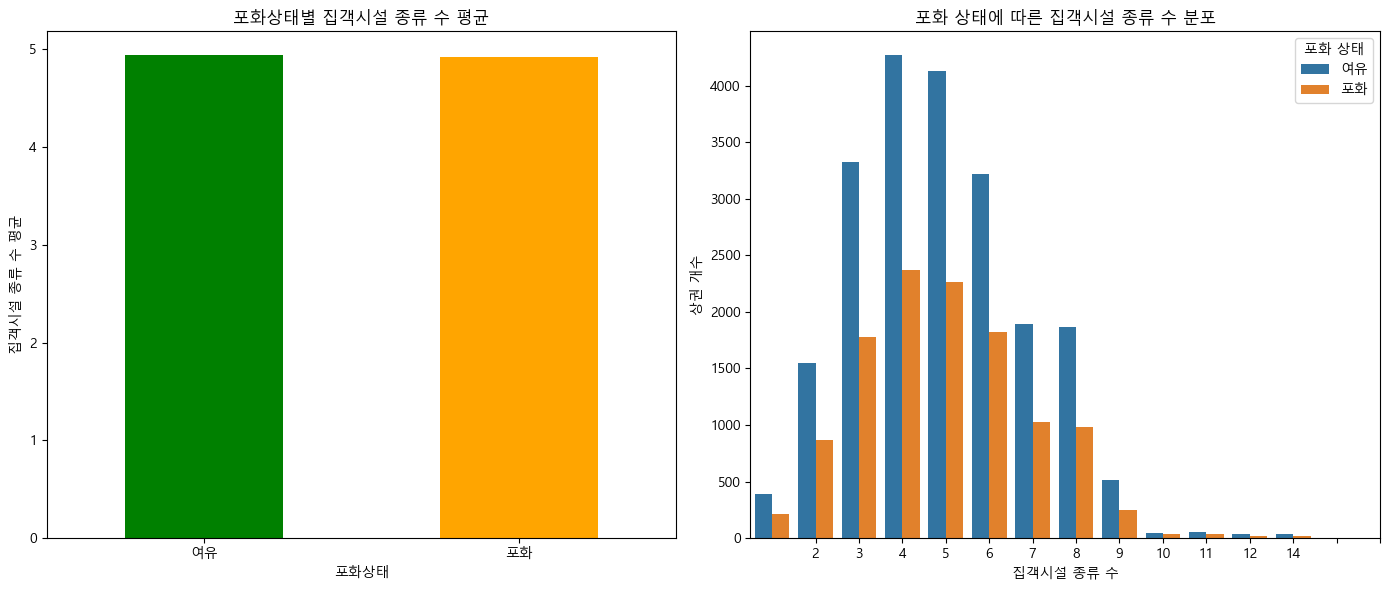

In [68]:
# 피겨 사이즈 설정
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 가로로 2개 배치

# 첫 번째 그래프: 포화상태별 집객시설 종류 수 평균 막대 그래프
average_by_many_state = data_hypo8.groupby('포화상태')['가설8_x'].mean()
average_by_many_state.plot(kind='bar', color=['green', 'orange', 'red'], ax=axes[0])

# 제목 및 레이블 설정
axes[0].set_title('포화상태별 집객시설 종류 수 평균')
axes[0].set_xlabel('포화상태')
axes[0].set_ylabel('집객시설 종류 수 평균')
axes[0].tick_params(axis='x', rotation=0)  # X축 레이블 회전 제거

# 두 번째 그래프: 점포수 vs 가설8_x (포화상태 별) 산점도
sns.countplot(data=data_hypo8, x='가설8_x', hue='포화상태')

# 제목 및 레이블 설정
axes[1].set_title('포화 상태에 따른 집객시설 종류 수 분포')
axes[1].set_xlabel('집객시설 종류 수')
axes[1].set_ylabel('상권 개수')
axes[1].legend(title='포화 상태')
axes[1].set_xticks(range(1,15))

# 그래프 출력
plt.tight_layout()  # 레이아웃 조정
plt.show()

### 통계분석

In [69]:
# 각 그룹별 집객시설 종류 수 추출
many = data_hypo8[data_hypo8['포화상태'] == '포화']['가설8_x']
less = data_hypo8[data_hypo8['포화상태'] == '여유']['가설8_x']

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many)
less_normality = stats.shapiro(less)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 2.2863342614944063e-48
less - p-value: 1.3948956581238043e-59
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11689.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21321.
  res = hypotest_fun_out(*samples, **kwds)


In [70]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many, less, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=124344526.0, p-value=0.7449387448947299


In [23]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo8['가설8_x'], data_hypo8['경쟁강도'])
print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")
# 스피어만 상관계수 
corr, p_value = spearmanr(data_hypo8['가설8_x'], data_hypo8['경쟁강도'])
print(f"스피어만 상관분석 결과: 상관계수={corr}, p-value={p_value}")
# Hoeffding's D
corr, p_value = sign_test(data_hypo8['가설8_x'], data_hypo8['경쟁강도'])
print(f"Hoeffding's D 상관분석 결과: 상관계수={corr}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=-0.004834752581634101, p-value=0.37973680000531496
스피어만 상관분석 결과: 상관계수=-0.0023974158775047112, p-value=0.6631543032875054
Hoeffding's D 상관분석 결과: 상관계수=16497.0, p-value=0.0


### 통계분석 (샘플링O)

In [91]:
# 각 그룹별 집객시설 종류 수 추출
many = data_hypo8[data_hypo8['포화상태'] == '포화']['가설8_x']
less = data_hypo8[data_hypo8['포화상태'] == '여유']['가설8_x']

# 두 그룹의 최소 샘플 크기 찾기 / 300개 랜덤샘플링 
min_size = 300

# 랜덤 샘플링 (seed 설정으로 재현성 확보)
np.random.seed(42)
many_sampled = np.random.choice(many, size=min_size, replace=False)
less_sampled = np.random.choice(less, size=min_size, replace=False)

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many_sampled)
less_normality = stats.shapiro(less_sampled)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 3.1439251305062404e-07
less - p-value: 4.350391255434097e-09
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


In [92]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many_sampled, less_sampled, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=43383.5, p-value=0.4406697940211719


In [ ]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo8['가설8_x'], data_hypo8['경쟁강도'])

print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=-0.004834752581634101, p-value=0.37973680000531496


## 가설 9 매출/점포비는 포화도에 영향을 미칠 것이다. 

### 데이터 준비

In [24]:
data_hypo9 = data_label.copy()

In [25]:
data_sale = data.groupby(['기준_년분기_코드','상권_코드_명'])['당월_매출_금액'].sum().reset_index()
data_hypo9 = pd.merge(data_hypo9, data_sale, on=['기준_년분기_코드','상권_코드_명'], how='left')

# 중복되는 데이터 drop 
data_hypo9.drop_duplicates(inplace=True)

# 데이터 확인
data_hypo9.reset_index(inplace=True)
data_hypo9.drop(columns='index',inplace=True)
data_hypo9

,기준_년분기_코드,상권_코드_명,행정동_코드_명,자치구_코드_명,유사_업종_점포_수,행정동 내 점포수,경쟁강도,포화상태,당월_매출_금액
0,20191,4.19민주묘지역 2번,우이동,강북구,34,282,0.120567,여유,2.712070e+08
1,20191,63빌딩,여의동,영등포구,70,2909,0.024063,여유,1.993332e+08
2,20191,DMC(디지털미디어시티),상암동,마포구,600,945,0.634921,포화,3.050783e+09
3,20191,GS강동자이아파트,길동,강동구,101,1698,0.059482,여유,5.969977e+08
4,20191,G타워,구로3동,구로구,26,2287,0.011369,여유,2.236545e+08
...,...,...,...,...,...,...,...,...,...
33005,20242,효창동주민센터,효창동,용산구,29,102,0.284314,포화,2.075966e+08
33006,20242,후암동주민센터,후암동,용산구,236,390,0.605128,포화,7.310171e+08
33007,20242,후암시장,후암동,용산구,57,390,0.146154,여유,8.607352e+08
33008,20242,휘문고교사거리,대치2동,강남구,80,1058,0.075614,여유,8.225593e+09


In [26]:
# 새로운 칼럼 추가 (매출/점포수)
data_hypo9['가설9_x'] = data_hypo9['당월_매출_금액']/data_hypo9['유사_업종_점포_수']

### 시각화 

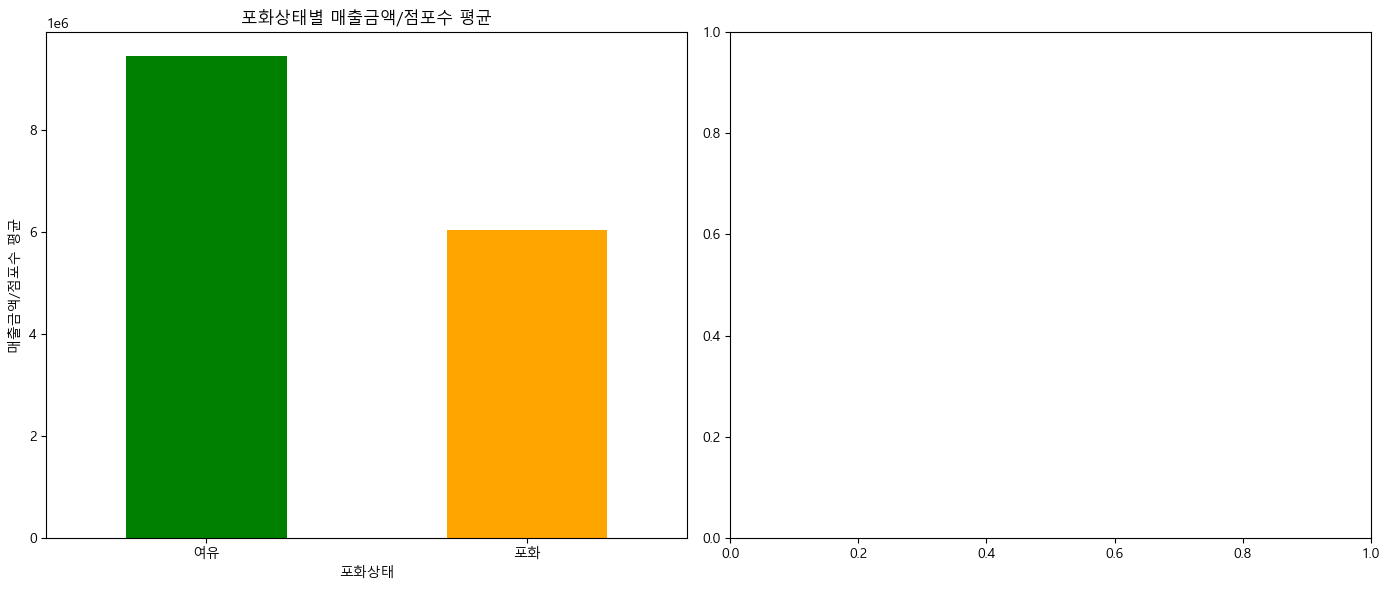

In [98]:
# 피겨 사이즈 설정
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 가로로 2개 배치

# 첫 번째 그래프: 포화상태별 가설9_x 평균 막대 그래프
average_by_many_state = data_hypo9.groupby('포화상태')['가설9_x'].mean()
average_by_many_state.plot(kind='bar', color=['green', 'orange', 'red'], ax=axes[0])

# 제목 및 레이블 설정
axes[0].set_title('포화상태별 매출금액/점포수 평균')
axes[0].set_xlabel('포화상태')
axes[0].set_ylabel('매출금액/점포수 평균')
axes[0].tick_params(axis='x', rotation=0)  # X축 레이블 회전 제거

# # 두 번째 그래프: 점포수 vs 가설9_x (포화상태 별) 산점도
# sns.scatterplot(data=data_hypo9, x="가설9_x", y="유사_업종_점포_수", hue="포화상태", palette="coolwarm")

# # 제목 및 레이블 설정
# axes[1].set_title('포화 상태에 따른 집객시설 종류 수 분포')
# axes[1].set_xlabel('집객시설 종류 수')
# axes[1].set_ylabel('상권 개수')
# axes[1].legend(title='포화 상태')
# axes[1].set_xticks(range(1,15))

# 그래프 출력
plt.tight_layout()  # 레이아웃 조정
plt.show()

### 통계분석

In [99]:
# 각 그룹별 집객시설 종류 수 추출
many = data_hypo9[data_hypo9['포화상태'] == '포화']['가설9_x']
less = data_hypo9[data_hypo9['포화상태'] == '여유']['가설9_x']

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many)
less_normality = stats.shapiro(less)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 1.1757936783356718e-88
less - p-value: 8.618988624575339e-128
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11689.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21321.
  res = hypotest_fun_out(*samples, **kwds)


In [100]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many, less, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=106122656.0, p-value=1.9593568158266664e-110


In [27]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo9['가설9_x'], data_hypo9['경쟁강도'])
print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")
# 스피어만 상관계수 
corr, p_value = spearmanr(data_hypo9['가설9_x'], data_hypo9['경쟁강도'])
print(f"스피어만 상관분석 결과: 상관계수={corr}, p-value={p_value}")
# Hoeffding's D
corr, p_value = sign_test(data_hypo9['가설9_x'], data_hypo9['경쟁강도'])
print(f"Hoeffding's D 상관분석 결과: 상관계수={corr}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=-0.10041164859147964, p-value=1.0127304603356687e-74
스피어만 상관분석 결과: 상관계수=-0.12683217234915944, p-value=1.9967519446252907e-118
Hoeffding's D 상관분석 결과: 상관계수=16505.0, p-value=0.0


### 통계분석 (샘플링O)

In [102]:
# 각 그룹별 집객시설 종류 수 추출
many = data_hypo9[data_hypo9['포화상태'] == '포화']['가설9_x']
less = data_hypo9[data_hypo9['포화상태'] == '여유']['가설9_x']

# 두 그룹의 최소 샘플 크기 찾기 / 300개 랜덤샘플링 
min_size = 300

# 랜덤 샘플링 (seed 설정으로 재현성 확보)
np.random.seed(42)
many_sampled = np.random.choice(many, size=min_size, replace=False)
less_sampled = np.random.choice(less, size=min_size, replace=False)

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many_sampled)
less_normality = stats.shapiro(less_sampled)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 8.998825303989757e-25
less - p-value: 1.1952236178425657e-32
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


In [103]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many_sampled, less_sampled, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=37574.0, p-value=0.000469639130807192


In [104]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo9['가설9_x'], data_hypo9['경쟁강도'])

print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=-0.10041164859147964, p-value=1.0127304603356687e-74


## 가설 10 매출금액/영역면적은 포화도와 상관이 있다. 

### 데이터 준비

In [28]:
data_hypo10 = data_label.copy()

In [29]:
data_sale = data.groupby(['기준_년분기_코드','상권_코드_명'])['당월_매출_금액'].sum().reset_index()
data_hypo10 = pd.merge(data_hypo10, data_sale, on=['기준_년분기_코드','상권_코드_명'], how='left')
data_hypo10 = pd.merge(data_hypo10, data[['기준_년분기_코드','상권_코드_명','영역_면적']], on=['기준_년분기_코드','상권_코드_명'], how='left')

# 중복되는 데이터 drop 
data_hypo10.drop_duplicates(inplace=True)

# 데이터 확인
data_hypo10.reset_index(inplace=True)
data_hypo10.drop(columns='index',inplace=True)
data_hypo10

,기준_년분기_코드,상권_코드_명,행정동_코드_명,자치구_코드_명,유사_업종_점포_수,행정동 내 점포수,경쟁강도,포화상태,당월_매출_금액,영역_면적
0,20191,4.19민주묘지역 2번,우이동,강북구,34,282,0.120567,여유,2.712070e+08,60794
1,20191,63빌딩,여의동,영등포구,70,2909,0.024063,여유,1.993332e+08,40709
2,20191,DMC(디지털미디어시티),상암동,마포구,600,945,0.634921,포화,3.050783e+09,347758
3,20191,GS강동자이아파트,길동,강동구,101,1698,0.059482,여유,5.969977e+08,81524
4,20191,G타워,구로3동,구로구,26,2287,0.011369,여유,2.236545e+08,84987
...,...,...,...,...,...,...,...,...,...,...
33005,20242,효창동주민센터,효창동,용산구,29,102,0.284314,포화,2.075966e+08,100249
33006,20242,후암동주민센터,후암동,용산구,236,390,0.605128,포화,7.310171e+08,293041
33007,20242,후암시장,후암동,용산구,57,390,0.146154,여유,8.607352e+08,33290
33008,20242,휘문고교사거리,대치2동,강남구,80,1058,0.075614,여유,8.225593e+09,133570


In [30]:
# 새로운 칼럼 추가 (매출금액/영역면적)
data_hypo10['가설10_x'] = data_hypo10['당월_매출_금액']/data_hypo10['영역_면적']

### 시각화 

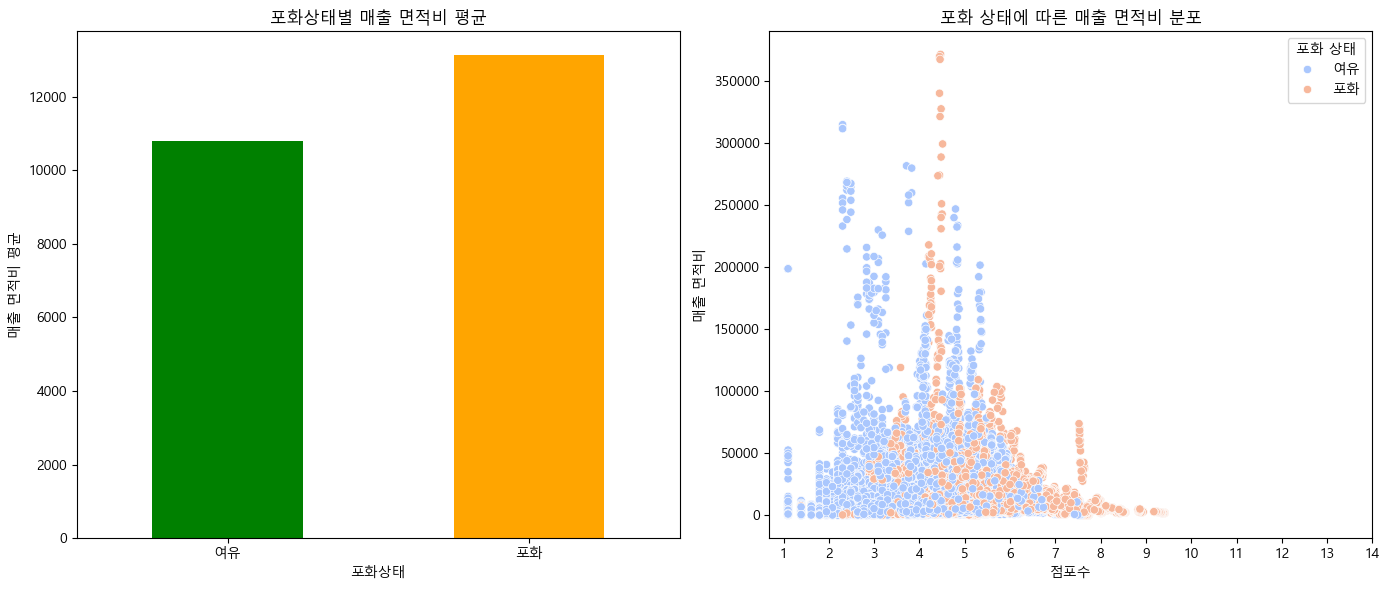

In [112]:
# 피겨 사이즈 설정
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 가로로 2개 배치

# 첫 번째 그래프: 포화상태별 집객시설 종류 수 평균 막대 그래프
average_by_many_state = data_hypo10.groupby('포화상태')['가설10_x'].mean()
average_by_many_state.plot(kind='bar', color=['green', 'orange', 'red'], ax=axes[0])

# 제목 및 레이블 설정
axes[0].set_title('포화상태별 매출 면적비 평균')
axes[0].set_xlabel('포화상태')
axes[0].set_ylabel('매출 면적비 평균')
axes[0].tick_params(axis='x', rotation=0)  # X축 레이블 회전 제거

# 두 번째 그래프: 점포수 vs 가설10_x (포화상태 별) 산점도
data_hypo10['유사_업종_점포_수_log'] = np.log(data_hypo10['유사_업종_점포_수'])
sns.scatterplot(data=data_hypo10, x="유사_업종_점포_수_log", y="가설10_x", hue="포화상태", palette="coolwarm")

# 제목 및 레이블 설정
axes[1].set_title('포화 상태에 따른 매출 면적비 분포')
axes[1].set_xlabel('점포수')
axes[1].set_ylabel('매출 면적비')
axes[1].legend(title='포화 상태')
axes[1].set_xticks(range(1,15))

# 그래프 출력
plt.tight_layout()  # 레이아웃 조정
plt.show()

### 통계분석

In [113]:
# 각 그룹별 집객시설 종류 수 추출
many = data_hypo10[data_hypo10['포화상태'] == '포화']['가설10_x']
less = data_hypo10[data_hypo10['포화상태'] == '여유']['가설10_x']

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many)
less_normality = stats.shapiro(less)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 1.657659296602708e-101
less - p-value: 1.3233276277759653e-120
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11689.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21321.
  res = hypotest_fun_out(*samples, **kwds)


In [114]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many, less, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=157047912.0, p-value=0.0


In [31]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo10['가설10_x'], data_hypo10['경쟁강도'])
print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")
# 스피어만 상관계수 
corr, p_value = spearmanr(data_hypo10['가설10_x'], data_hypo10['경쟁강도'])
print(f"스피어만 상관분석 결과: 상관계수={corr}, p-value={p_value}")
# Hoeffding's D
corr, p_value = sign_test(data_hypo10['가설10_x'], data_hypo10['경쟁강도'])
print(f"Hoeffding's D 상관분석 결과: 상관계수={corr}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=0.07626220781629428, p-value=8.916747176360503e-44
스피어만 상관분석 결과: 상관계수=0.28793677642631793, p-value=0.0
Hoeffding's D 상관분석 결과: 상관계수=16503.0, p-value=0.0


### 통계분석 (샘플링O)

In [116]:
# 각 그룹별 집객시설 종류 수 추출
many = data_hypo10[data_hypo10['포화상태'] == '포화']['가설10_x']
less = data_hypo10[data_hypo10['포화상태'] == '여유']['가설10_x']

# 두 그룹의 최소 샘플 크기 찾기 / 300개 랜덤샘플링 
min_size = 300

# 랜덤 샘플링 (seed 설정으로 재현성 확보)
np.random.seed(42)
many_sampled = np.random.choice(many, size=min_size, replace=False)
less_sampled = np.random.choice(less, size=min_size, replace=False)

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many_sampled)
less_normality = stats.shapiro(less_sampled)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 7.759259723356143e-22
less - p-value: 2.623514966649328e-30
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


In [117]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many_sampled, less_sampled, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=55433.0, p-value=8.931214714856893e-07


In [118]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo10['가설10_x'], data_hypo10['경쟁강도'])

print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=0.07626220781629428, p-value=8.916747176360503e-44


## 가설 11 매출금액/총 유동인구 수는 포화도와 상관이 있다. 

### 데이터 준비

In [32]:
data_hypo11 = data_label.copy()

In [33]:
data_sale = data.groupby(['기준_년분기_코드','상권_코드_명'])['당월_매출_금액'].sum().reset_index()
data_hypo11 = pd.merge(data_hypo11, data_sale, on=['기준_년분기_코드','상권_코드_명'], how='left')
data_hypo11 = pd.merge(data_hypo11, data[['기준_년분기_코드','상권_코드_명','총_유동인구_수']], on=['기준_년분기_코드','상권_코드_명'], how='left')

# 중복되는 데이터 drop 
data_hypo11.drop_duplicates(inplace=True)

# 데이터 확인
data_hypo11.reset_index(inplace=True)
data_hypo11.drop(columns='index',inplace=True)
data_hypo11

,기준_년분기_코드,상권_코드_명,행정동_코드_명,자치구_코드_명,유사_업종_점포_수,행정동 내 점포수,경쟁강도,포화상태,당월_매출_금액,총_유동인구_수
0,20191,4.19민주묘지역 2번,우이동,강북구,34,282,0.120567,여유,2.712070e+08,522050
1,20191,63빌딩,여의동,영등포구,70,2909,0.024063,여유,1.993332e+08,57752
2,20191,DMC(디지털미디어시티),상암동,마포구,600,945,0.634921,포화,3.050783e+09,519877
3,20191,GS강동자이아파트,길동,강동구,101,1698,0.059482,여유,5.969977e+08,1049177
4,20191,G타워,구로3동,구로구,26,2287,0.011369,여유,2.236545e+08,351183
...,...,...,...,...,...,...,...,...,...,...
33005,20242,효창동주민센터,효창동,용산구,29,102,0.284314,포화,2.075966e+08,1256249
33006,20242,후암동주민센터,후암동,용산구,236,390,0.605128,포화,7.310171e+08,2083218
33007,20242,후암시장,후암동,용산구,57,390,0.146154,여유,8.607352e+08,177952
33008,20242,휘문고교사거리,대치2동,강남구,80,1058,0.075614,여유,8.225593e+09,336751


In [34]:
# 새로운 칼럼 추가 (매출금액/유동인구)
data_hypo11['가설11_x'] = data_hypo11['당월_매출_금액']/data_hypo11['총_유동인구_수']

### 시각화 

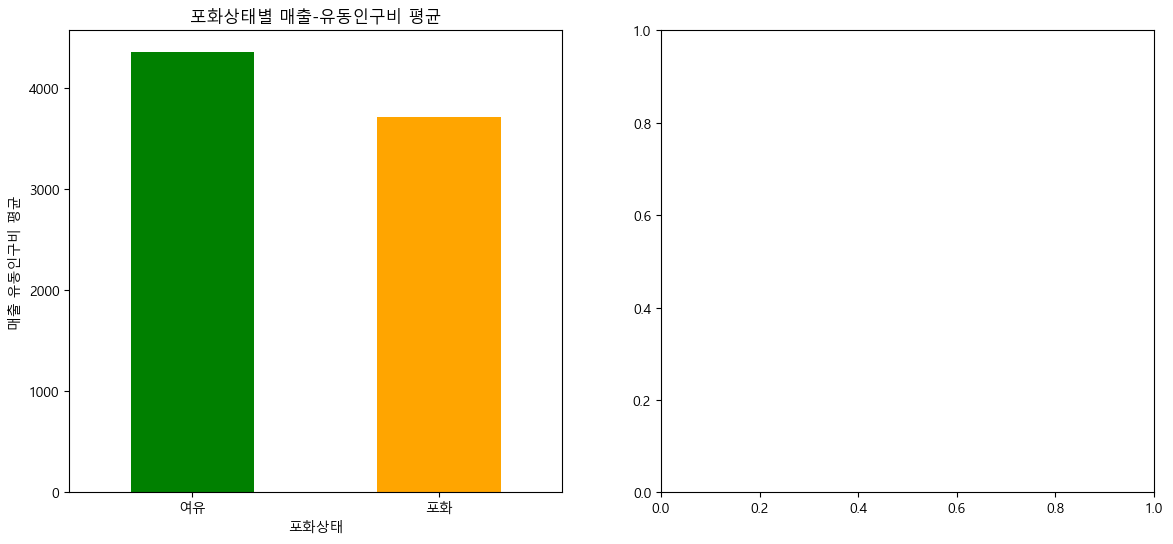

In [126]:
# 피겨 사이즈 설정
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 가로로 2개 배치

# 첫 번째 그래프: 포화상태별 집객시설 종류 수 평균 막대 그래프
average_by_many_state = data_hypo11.groupby('포화상태')['가설11_x'].mean()
average_by_many_state.plot(kind='bar', color=['green', 'orange', 'red'], ax=axes[0])

# 제목 및 레이블 설정
axes[0].set_title('포화상태별 매출-유동인구비 평균')
axes[0].set_xlabel('포화상태')
axes[0].set_ylabel('매출 유동인구비 평균')
axes[0].tick_params(axis='x', rotation=0)  # X축 레이블 회전 제거

# # 두 번째 그래프: 점포수 vs 가설11_x (포화상태 별) 산점도
# data_hypo11['유사_업종_점포_수_log'] = np.log(data_hypo11['유사_업종_점포_수'])
# sns.scatterplot(data=data_hypo11, x="유사_업종_점포_수_log", y="가설11_x", hue="포화상태", palette="coolwarm")

# # 제목 및 레이블 설정
# axes[1].set_title('포화 상태에 따른 매출 면적비 분포')
# axes[1].set_xlabel('점포수')
# axes[1].set_ylabel('매출 면적비')
# axes[1].legend(title='포화 상태')
# axes[1].set_xticks(range(1,15))

# # 그래프 출력
# plt.tight_layout()  # 레이아웃 조정
# plt.show()

### 통계분석

In [127]:
# 각 그룹별 집객시설 종류 수 추출
many = data_hypo11[data_hypo11['포화상태'] == '포화']['가설11_x']
less = data_hypo11[data_hypo11['포화상태'] == '여유']['가설11_x']

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many)
less_normality = stats.shapiro(less)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 4.712996004077938e-117
less - p-value: 9.589902596637727e-138
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11689.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21321.
  res = hypotest_fun_out(*samples, **kwds)


In [128]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many, less, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=153212436.0, p-value=1.801216536925049e-261


In [35]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo11['가설11_x'], data_hypo11['경쟁강도'])
print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")
# 스피어만 상관계수 
corr, p_value = spearmanr(data_hypo11['가설11_x'], data_hypo11['경쟁강도'])
print(f"스피어만 상관분석 결과: 상관계수={corr}, p-value={p_value}")
# Hoeffding's D
corr, p_value = sign_test(data_hypo11['가설11_x'], data_hypo11['경쟁강도'])
print(f"Hoeffding's D 상관분석 결과: 상관계수={corr}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=1.6610900317722086e-05, p-value=0.9975920975405248
스피어만 상관분석 결과: 상관계수=0.24547906380725384, p-value=0.0
Hoeffding's D 상관분석 결과: 상관계수=16503.0, p-value=0.0


### 통계분석 (샘플링O)

In [130]:
# 각 그룹별 집객시설 종류 수 추출
many = data_hypo11[data_hypo11['포화상태'] == '포화']['가설11_x']
less = data_hypo11[data_hypo11['포화상태'] == '여유']['가설11_x']

# 두 그룹의 최소 샘플 크기 찾기 / 300개 랜덤샘플링 
min_size = 300

# 랜덤 샘플링 (seed 설정으로 재현성 확보)
np.random.seed(42)
many_sampled = np.random.choice(many, size=min_size, replace=False)
less_sampled = np.random.choice(less, size=min_size, replace=False)

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many_sampled)
less_normality = stats.shapiro(less_sampled)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 9.985629306745082e-31
less - p-value: 3.231219819752621e-32
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


In [131]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many_sampled, less_sampled, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=55506.0, p-value=7.489584780053669e-07


In [132]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo11['가설11_x'], data_hypo11['경쟁강도'])

print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=1.6610900317722086e-05, p-value=0.9975920975405248


## 가설 12 점포 밀도는 포화도와 상관이 있다.

### 데이터 준비

In [36]:
data_hypo12 = data_label.copy()

In [37]:
data_hypo12 = pd.merge(data_hypo12, data[['기준_년분기_코드','상권_코드_명','영역_면적']], on=['기준_년분기_코드','상권_코드_명'], how='left')

# 중복되는 데이터 drop 
data_hypo12.drop_duplicates(inplace=True)

# 데이터 확인
data_hypo12.reset_index(inplace=True)
data_hypo12.drop(columns='index',inplace=True)
data_hypo12

,기준_년분기_코드,상권_코드_명,행정동_코드_명,자치구_코드_명,유사_업종_점포_수,행정동 내 점포수,경쟁강도,포화상태,영역_면적
0,20191,4.19민주묘지역 2번,우이동,강북구,34,282,0.120567,여유,60794
1,20191,63빌딩,여의동,영등포구,70,2909,0.024063,여유,40709
2,20191,DMC(디지털미디어시티),상암동,마포구,600,945,0.634921,포화,347758
3,20191,GS강동자이아파트,길동,강동구,101,1698,0.059482,여유,81524
4,20191,G타워,구로3동,구로구,26,2287,0.011369,여유,84987
...,...,...,...,...,...,...,...,...,...
33005,20242,효창동주민센터,효창동,용산구,29,102,0.284314,포화,100249
33006,20242,후암동주민센터,후암동,용산구,236,390,0.605128,포화,293041
33007,20242,후암시장,후암동,용산구,57,390,0.146154,여유,33290
33008,20242,휘문고교사거리,대치2동,강남구,80,1058,0.075614,여유,133570


In [38]:
# 새로운 칼럼 추가 (매출금액/유동인구)
data_hypo12['가설12_x'] = data_hypo12['유사_업종_점포_수']/data_hypo12['영역_면적']

### 시각화 

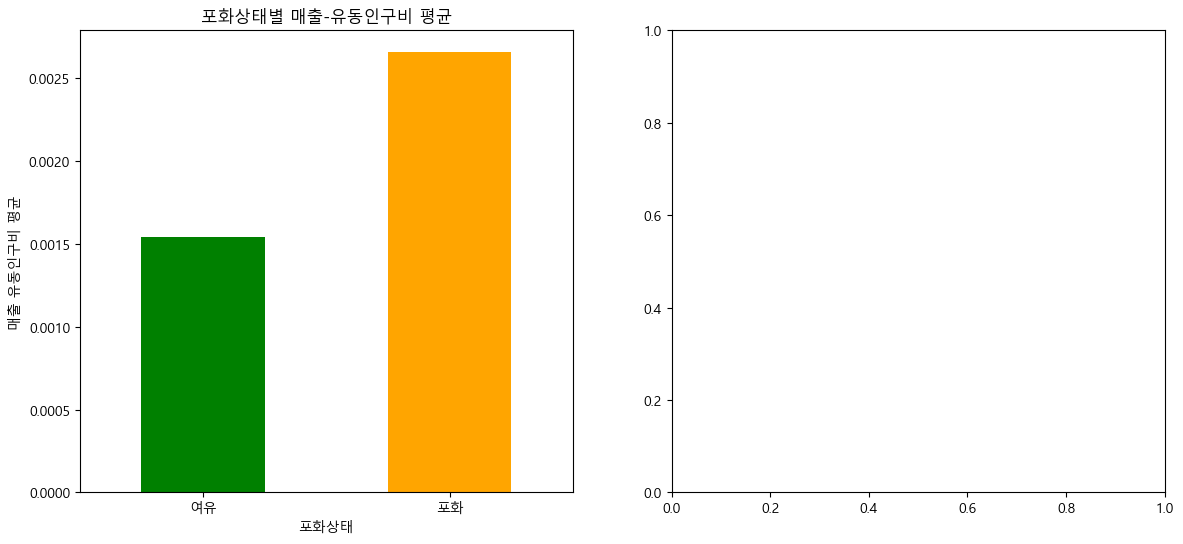

In [43]:
# 피겨 사이즈 설정
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 가로로 2개 배치

# 첫 번째 그래프: 포화상태별 집객시설 종류 수 평균 막대 그래프
average_by_many_state = data_hypo12.groupby('포화상태')['가설12_x'].mean()
average_by_many_state.plot(kind='bar', color=['green', 'orange', 'red'], ax=axes[0])

# 제목 및 레이블 설정
axes[0].set_title('포화상태별 매출-유동인구비 평균')
axes[0].set_xlabel('포화상태')
axes[0].set_ylabel('매출 유동인구비 평균')
axes[0].tick_params(axis='x', rotation=0)  # X축 레이블 회전 제거

# # 두 번째 그래프: 점포수 vs 가설11_x (포화상태 별) 산점도
# data_hypo11['유사_업종_점포_수_log'] = np.log(data_hypo11['유사_업종_점포_수'])
# sns.scatterplot(data=data_hypo11, x="유사_업종_점포_수_log", y="가설11_x", hue="포화상태", palette="coolwarm")

# # 제목 및 레이블 설정
# axes[1].set_title('포화 상태에 따른 매출 면적비 분포')
# axes[1].set_xlabel('점포수')
# axes[1].set_ylabel('매출 면적비')
# axes[1].legend(title='포화 상태')
# axes[1].set_xticks(range(1,15))

# # 그래프 출력
# plt.tight_layout()  # 레이아웃 조정
# plt.show()

### 통계분석

In [44]:
# 각 그룹별 집객시설 종류 수 추출
many = data_hypo12[data_hypo12['포화상태'] == '포화']['가설12_x']
less = data_hypo12[data_hypo12['포화상태'] == '여유']['가설12_x']

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many)
less_normality = stats.shapiro(less)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 1.4057084937420094e-114
less - p-value: 1.180974848111588e-130
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11689.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21321.
  res = hypotest_fun_out(*samples, **kwds)


In [45]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many, less, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=179252211.0, p-value=0.0


In [39]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo12['가설12_x'], data_hypo12['경쟁강도'])
print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")
# 스피어만 상관계수 
corr, p_value = spearmanr(data_hypo12['가설12_x'], data_hypo12['경쟁강도'])
print(f"스피어만 상관분석 결과: 상관계수={corr}, p-value={p_value}")
# Hoeffding's D
corr, p_value = sign_test(data_hypo12['가설12_x'], data_hypo12['경쟁강도'])
print(f"Hoeffding's D 상관분석 결과: 상관계수={corr}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=0.09504947752436566, p-value=4.111571986020253e-67
스피어만 상관분석 결과: 상관계수=0.46291618142832525, p-value=0.0
Hoeffding's D 상관분석 결과: 상관계수=-16461.0, p-value=0.0


### 통계분석 (샘플링O)

In [47]:
# 각 그룹별 집객시설 종류 수 추출
many = data_hypo12[data_hypo12['포화상태'] == '포화']['가설12_x']
less = data_hypo12[data_hypo12['포화상태'] == '여유']['가설12_x']

# 두 그룹의 최소 샘플 크기 찾기 / 300개 랜덤샘플링 
min_size = 300

# 랜덤 샘플링 (seed 설정으로 재현성 확보)
np.random.seed(42)
many_sampled = np.random.choice(many, size=min_size, replace=False)
less_sampled = np.random.choice(less, size=min_size, replace=False)

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many_sampled)
less_normality = stats.shapiro(less_sampled)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 4.049600923392271e-20
less - p-value: 7.854225402461857e-33
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


In [48]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many_sampled, less_sampled, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=62361.0, p-value=2.90979561734111e-16


In [49]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo12['가설12_x'], data_hypo12['경쟁강도'])

print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=0.09504947752436566, p-value=4.111571986020253e-67


## 가설 13 프랜차이즈 비율은 포화도와 상관이 있다. 

### 데이터 준비

In [40]:
data_hypo13 = data_label.copy()

In [41]:
data_fr = data.groupby(['기준_년분기_코드', '상권_코드_명'])['프랜차이즈_점포_수'].sum().reset_index()
data_hypo13 = pd.merge(data_hypo13, data_fr, on=['기준_년분기_코드','상권_코드_명'], how='left')

# 중복되는 데이터 drop 
data_hypo13.drop_duplicates(inplace=True)

# 데이터 확인
data_hypo13.reset_index(inplace=True)
data_hypo13.drop(columns='index',inplace=True)
data_hypo13

,기준_년분기_코드,상권_코드_명,행정동_코드_명,자치구_코드_명,유사_업종_점포_수,행정동 내 점포수,경쟁강도,포화상태,프랜차이즈_점포_수
0,20191,4.19민주묘지역 2번,우이동,강북구,34,282,0.120567,여유,5
1,20191,63빌딩,여의동,영등포구,70,2909,0.024063,여유,6
2,20191,DMC(디지털미디어시티),상암동,마포구,600,945,0.634921,포화,150
3,20191,GS강동자이아파트,길동,강동구,101,1698,0.059482,여유,13
4,20191,G타워,구로3동,구로구,26,2287,0.011369,여유,8
...,...,...,...,...,...,...,...,...,...
33005,20242,효창동주민센터,효창동,용산구,29,102,0.284314,포화,1
33006,20242,후암동주민센터,후암동,용산구,236,390,0.605128,포화,18
33007,20242,후암시장,후암동,용산구,57,390,0.146154,여유,9
33008,20242,휘문고교사거리,대치2동,강남구,80,1058,0.075614,여유,10


In [42]:
# 새로운 칼럼 추가 (매출금액/유동인구)
data_hypo13['가설13_x'] = data_hypo13['프랜차이즈_점포_수']/data_hypo13['유사_업종_점포_수']

### 시각화 

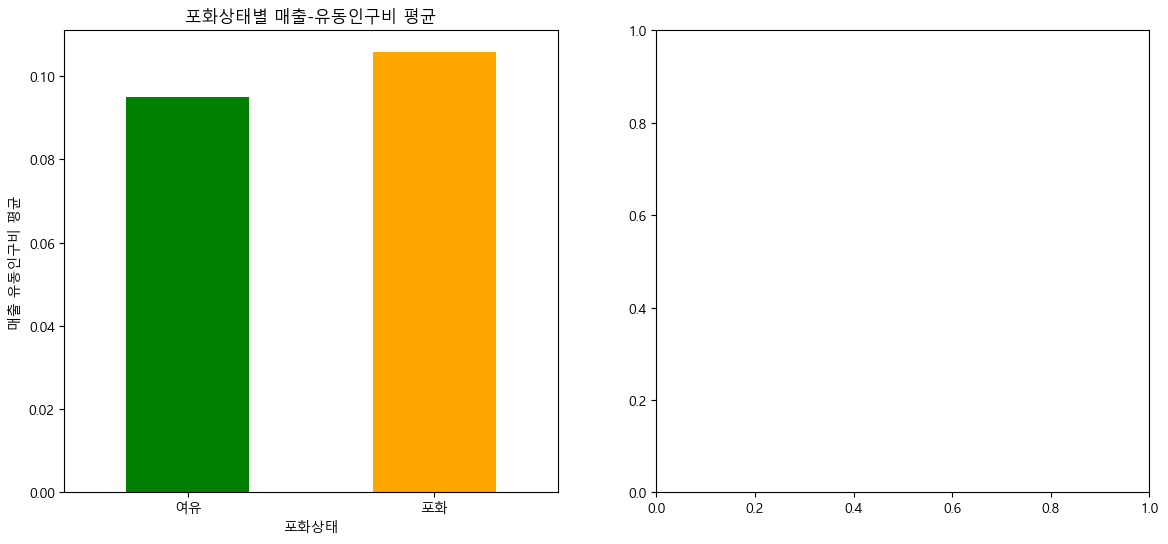

In [54]:
# 피겨 사이즈 설정
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 가로로 2개 배치

# 첫 번째 그래프: 포화상태별 집객시설 종류 수 평균 막대 그래프
average_by_many_state = data_hypo13.groupby('포화상태')['가설13_x'].mean()
average_by_many_state.plot(kind='bar', color=['green', 'orange', 'red'], ax=axes[0])

# 제목 및 레이블 설정
axes[0].set_title('포화상태별 매출-유동인구비 평균')
axes[0].set_xlabel('포화상태')
axes[0].set_ylabel('매출 유동인구비 평균')
axes[0].tick_params(axis='x', rotation=0)  # X축 레이블 회전 제거

# # 두 번째 그래프: 점포수 vs 가설11_x (포화상태 별) 산점도
# data_hypo11['유사_업종_점포_수_log'] = np.log(data_hypo11['유사_업종_점포_수'])
# sns.scatterplot(data=data_hypo11, x="유사_업종_점포_수_log", y="가설11_x", hue="포화상태", palette="coolwarm")

# # 제목 및 레이블 설정
# axes[1].set_title('포화 상태에 따른 매출 면적비 분포')
# axes[1].set_xlabel('점포수')
# axes[1].set_ylabel('매출 면적비')
# axes[1].legend(title='포화 상태')
# axes[1].set_xticks(range(1,15))

# # 그래프 출력
# plt.tight_layout()  # 레이아웃 조정
# plt.show()

### 통계분석

In [55]:
# 각 그룹별 집객시설 종류 수 추출
many = data_hypo13[data_hypo13['포화상태'] == '포화']['가설13_x']
less = data_hypo13[data_hypo13['포화상태'] == '여유']['가설13_x']

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many)
less_normality = stats.shapiro(less)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 6.754779997096133e-55
less - p-value: 8.270465736535611e-95
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11689.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21321.
  res = hypotest_fun_out(*samples, **kwds)


In [56]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many, less, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=148234444.0, p-value=8.722482302948993e-180


In [43]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo13['가설13_x'], data_hypo13['경쟁강도'])
print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")
# 스피어만 상관계수 
corr, p_value = spearmanr(data_hypo13['가설13_x'], data_hypo13['경쟁강도'])
print(f"스피어만 상관분석 결과: 상관계수={corr}, p-value={p_value}")
# Hoeffding's D
corr, p_value = sign_test(data_hypo13['가설13_x'], data_hypo13['경쟁강도'])
print(f"Hoeffding's D 상관분석 결과: 상관계수={corr}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=0.0778183389632775, p-value=1.631879180486831e-45
스피어만 상관분석 결과: 상관계수=0.21933677074183291, p-value=0.0
Hoeffding's D 상관분석 결과: 상관계수=-8054.0, p-value=0.0


### 통계분석 (샘플링O)

In [59]:
# 각 그룹별 집객시설 종류 수 추출
many = data_hypo13[data_hypo13['포화상태'] == '포화']['가설13_x']
less = data_hypo13[data_hypo13['포화상태'] == '여유']['가설13_x']

# 두 그룹의 최소 샘플 크기 찾기 / 300개 랜덤샘플링 
min_size = 300

# 랜덤 샘플링 (seed 설정으로 재현성 확보)
np.random.seed(42)
many_sampled = np.random.choice(many, size=min_size, replace=False)
less_sampled = np.random.choice(less, size=min_size, replace=False)

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many_sampled)
less_normality = stats.shapiro(less_sampled)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 4.109061357887204e-08
less - p-value: 7.144295520132984e-20
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


In [60]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many_sampled, less_sampled, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=51777.0, p-value=0.0014038458276247855


In [61]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo13['가설13_x'], data_hypo13['경쟁강도'])

print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=0.0778183389632775, p-value=1.631879180486831e-45


## 가설 14 유동인구 면적비는 포화도와 상관이 있다. 

### 데이터 준비

In [44]:
data_hypo14 = data_label.copy()

In [45]:
data_hypo14 = pd.merge(data_hypo14, data[['기준_년분기_코드','상권_코드_명','총_유동인구_수','영역_면적']], on=['기준_년분기_코드','상권_코드_명'], how='left')

# 중복되는 데이터 drop 
data_hypo14.drop_duplicates(inplace=True)

# 데이터 확인
data_hypo14.reset_index(inplace=True)
data_hypo14.drop(columns='index',inplace=True)
data_hypo14

,기준_년분기_코드,상권_코드_명,행정동_코드_명,자치구_코드_명,유사_업종_점포_수,행정동 내 점포수,경쟁강도,포화상태,총_유동인구_수,영역_면적
0,20191,4.19민주묘지역 2번,우이동,강북구,34,282,0.120567,여유,522050,60794
1,20191,63빌딩,여의동,영등포구,70,2909,0.024063,여유,57752,40709
2,20191,DMC(디지털미디어시티),상암동,마포구,600,945,0.634921,포화,519877,347758
3,20191,GS강동자이아파트,길동,강동구,101,1698,0.059482,여유,1049177,81524
4,20191,G타워,구로3동,구로구,26,2287,0.011369,여유,351183,84987
...,...,...,...,...,...,...,...,...,...,...
33005,20242,효창동주민센터,효창동,용산구,29,102,0.284314,포화,1256249,100249
33006,20242,후암동주민센터,후암동,용산구,236,390,0.605128,포화,2083218,293041
33007,20242,후암시장,후암동,용산구,57,390,0.146154,여유,177952,33290
33008,20242,휘문고교사거리,대치2동,강남구,80,1058,0.075614,여유,336751,133570


In [46]:
# 새로운 칼럼 추가 (매출금액/유동인구)
data_hypo14['가설14_x'] = data_hypo14['총_유동인구_수']/data_hypo14['영역_면적']

### 시각화 

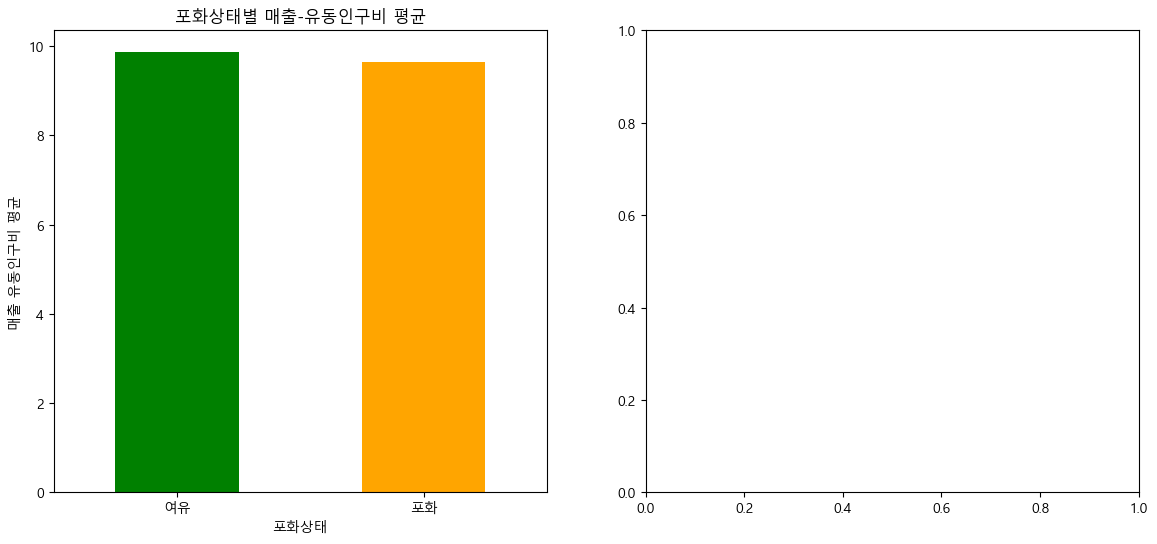

In [65]:
# 피겨 사이즈 설정
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 가로로 2개 배치

# 첫 번째 그래프: 포화상태별 집객시설 종류 수 평균 막대 그래프
average_by_many_state = data_hypo14.groupby('포화상태')['가설14_x'].mean()
average_by_many_state.plot(kind='bar', color=['green', 'orange', 'red'], ax=axes[0])

# 제목 및 레이블 설정
axes[0].set_title('포화상태별 매출-유동인구비 평균')
axes[0].set_xlabel('포화상태')
axes[0].set_ylabel('매출 유동인구비 평균')
axes[0].tick_params(axis='x', rotation=0)  # X축 레이블 회전 제거

# # 두 번째 그래프: 점포수 vs 가설11_x (포화상태 별) 산점도
# data_hypo11['유사_업종_점포_수_log'] = np.log(data_hypo11['유사_업종_점포_수'])
# sns.scatterplot(data=data_hypo11, x="유사_업종_점포_수_log", y="가설11_x", hue="포화상태", palette="coolwarm")

# # 제목 및 레이블 설정
# axes[1].set_title('포화 상태에 따른 매출 면적비 분포')
# axes[1].set_xlabel('점포수')
# axes[1].set_ylabel('매출 면적비')
# axes[1].legend(title='포화 상태')
# axes[1].set_xticks(range(1,15))

# # 그래프 출력
# plt.tight_layout()  # 레이아웃 조정
# plt.show()

### 통계분석

In [66]:
# 각 그룹별 집객시설 종류 수 추출
many = data_hypo14[data_hypo14['포화상태'] == '포화']['가설14_x']
less = data_hypo14[data_hypo14['포화상태'] == '여유']['가설14_x']

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many)
less_normality = stats.shapiro(less)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 6.526385242904133e-86
less - p-value: 1.7037494896114117e-101
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11689.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21321.
  res = hypotest_fun_out(*samples, **kwds)


In [67]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many, less, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=124686845.0, p-value=0.9266175793490224


In [47]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo14['가설14_x'], data_hypo14['경쟁강도'])
print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")
# 스피어만 상관계수 
corr, p_value = spearmanr(data_hypo14['가설14_x'], data_hypo14['경쟁강도'])
print(f"스피어만 상관분석 결과: 상관계수={corr}, p-value={p_value}")
# Hoeffding's D
corr, p_value = sign_test(data_hypo14['가설14_x'], data_hypo14['경쟁강도'])
print(f"Hoeffding's D 상관분석 결과: 상관계수={corr}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=-0.020045716537107308, p-value=0.00027024968985477147
스피어만 상관분석 결과: 상관계수=0.024734589443760533, p-value=6.974689858102273e-06
Hoeffding's D 상관분석 결과: 상관계수=16270.0, p-value=0.0


### 통계분석 (샘플링O)

In [75]:
# 각 그룹별 집객시설 종류 수 추출
many = data_hypo14[data_hypo14['포화상태'] == '포화']['가설14_x']
less = data_hypo14[data_hypo14['포화상태'] == '여유']['가설14_x']

# 두 그룹의 최소 샘플 크기 찾기 / 300개 랜덤샘플링 
min_size = 300

# 랜덤 샘플링 (seed 설정으로 재현성 확보)
np.random.seed(42)
many_sampled = np.random.choice(many, size=min_size, replace=False)
less_sampled = np.random.choice(less, size=min_size, replace=False)

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many_sampled)
less_normality = stats.shapiro(less_sampled)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 1.7403155611336894e-15
less - p-value: 8.697444409907191e-29
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


In [76]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many_sampled, less_sampled, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=42322.0, p-value=0.20726017782818762


In [71]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo14['가설14_x'], data_hypo14['경쟁강도'])

print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=-0.020045716537107308, p-value=0.00027024968985477147
